In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent
from igraph import Graph

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = GraphGame
    env = Environment(game)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env, attacker,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = GraphGame
    env = Environment(game)
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    '''game = GraphGame
    env = Environment(game)'''
    action_list = np.loadtxt(fname, dtype=int)
    rewards, lcc, actions = EvaluateACTION(action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(22, 20))
    AUC  = []
    NodeRemoved = []
    model_name = ["MIX","BA","FINDER","CI","GDM","COREHD"]
    for i, graph_name in enumerate(file_list):
        print(graph_name, end=' ,')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        print(actions_mix)
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        print(actions_ba)

        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        print(actions_Finder)
        #Re Insert CI
        path = "./ReI_CI/"
        fname = path+graph_name+".txt"
        rewards_ReI_CI, lcc_ReI_CI, actions_ReI_CI = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_ReI_CI)
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_CI)
        
        #GDM
        path = "./GDM/"
        fname = path+graph_name+".txt"
        rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_GDM)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),map)
        print(actions_CoreHD)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''

        x =  np.flip(np.arange(N+1)[N:0:-1]/N)

        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'Green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'Red',label='Trained Attacker [BA model]')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'Aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_GDM)],np.array(lcc_GDM)/N, 'Blue',label='GDM')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ReI_CI)],np.array(lcc_ReI_CI)/N, 'Pink',label='ReI_CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'Orange',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'Brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_GDM = area_under_curve(x[:len(lcc_GDM)],lcc_GDM)
        auc_ReI_CI = area_under_curve(x[:len(lcc_ReI_CI)],lcc_ReI_CI)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_ReI_CI,auc_CI,auc_GDM,auc_CoreHD],dtype='O')
        
        actions_all = [actions_mix,actions_ba,actions_Finder,actions_ReI_CI,actions_CI,actions_GDM,actions_CoreHD]
        fractionNode = np.array([len(xi) for xi in actions_all],dtype='O')/N
        
        #Save it as a string array
        auc_idx = np.flatnonzero(np.array(auc_all,dtype='O') == np.array(auc_all,dtype='O').min()) # index of best auc
        fracNode_idx = np.flatnonzero(np.array(fractionNode ,dtype='O') == np.array(fractionNode ,dtype='O').min()) # index of best fraction_node
        auc_all= ["%.4f" % action for action in auc_all]
        fractionNode= ["%.3f" % action for action in fractionNode]
        for idx in auc_idx:
            auc_all[idx] = r"\cellcolor{blue!25}"+ auc_all[idx]
        for idx in fracNode_idx:
            fractionNode[idx] = r'\cellcolor{blue!25}'+ str(fractionNode[idx])
        AUC.append(np.insert(auc_all,0,graph_name.replace("_", " ")))
        NodeRemoved.append(np.insert(fractionNode,0,graph_name.replace("_", " ")))
    print()
    np.savetxt("./Figure/Compiled/HDA/AUC_"+title+".tex", AUC,delimiter=" & ",newline = "\\\\ \n", fmt=('%s','%s','%s','%s','%s','%s','%s','%s')) 
    np.savetxt("./Figure/Compiled/HDA/Removed_"+title+".tex", NodeRemoved,delimiter=" & ",newline = "\\\\ \n",fmt=('%s','%s','%s','%s','%s','%s','%s','%s')) 
    figure.text(0.5, 0.075,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.075, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    #plt.legend(handles=[l1, l2, l3, l4, l5, l6, l7],loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True, bbox_transform=figure.transFigure)
    plt.savefig("./Figure/Compiled/HDA/"+title+".pdf")
    plt.show()

# Synthetic Network:

## BA Graph

barabasi_albert_30 ,[0, 3, 5, 7, 6, 2, 1, 23, 8, 25, 20, 19, 22, 16, 4]
[0, 3, 5, 7, 6, 2, 8, 23, 1, 25, 20, 16, 4, 14, 17, 15]
[12, 0, 11, 6, 2, 3, 13, 7, 1, 14, 9, 18, 8, 10, 25, 22]
[12, 6, 7, 9, 13, 2, 3, 11, 1, 15, 18, 22, 20, 21, 16, 19, 27, 23, 26, 4, 5, 24, 29, 17, 28, 8, 25, 14, 10]
[0, 3, 6, 11, 7, 2, 12, 13, 1, 14, 8, 17, 5, 16, 19, 26, 27, 4, 15, 23, 18, 21, 24, 9, 10, 25, 22, 29, 20, 28]
[3, 0, 6, 5, 23, 8, 7, 2, 1, 25, 13, 21, 16, 22, 20, 4, 14, 24, 29, 9, 17, 28, 18, 15, 26, 27, 19, 11, 10, 12]
[0, 3, 26, 6, 27, 16, 7, 29, 11, 19, 1, 5, 23, 13, 10, 15, 28, 9, 2, 21, 25, 12, 24, 18, 17, 4, 8, 20, 22, 14]
barabasi_albert_50 ,[4, 27, 0, 1, 14, 8, 2, 28, 3, 49, 6, 5, 39, 34, 16, 29, 17, 18, 40, 24, 23, 7, 45, 10]
[4, 27, 0, 1, 14, 8, 2, 28, 3, 49, 6, 5, 39, 40, 16, 29, 45, 41, 22, 11, 9, 25, 21, 32, 44, 13, 31, 34, 23, 24, 7, 17, 26]
[1, 6, 15, 8, 7, 2, 23, 5, 0, 4, 3, 10, 24, 19, 13, 36, 20, 31, 21, 12, 11, 29, 9, 46, 43, 18]
[13, 9, 6, 15, 1, 8, 31, 7, 11, 18, 19, 4, 24, 0

[3, 0, 398, 1, 213, 284, 452, 323, 4, 300, 354, 7, 12, 378, 14, 15, 468, 8, 380, 30, 476, 59, 6, 424, 275, 290, 127, 23, 221, 328, 252, 26, 281, 2, 412, 28, 340, 414, 276, 388, 11, 348, 167, 18, 440, 369, 36, 255, 139, 185, 5, 337, 458, 457, 27, 212, 309, 58, 156, 218, 45, 418, 262, 76, 108, 409, 473, 306, 52, 80, 138, 38, 85, 372, 158, 83, 161, 56, 277, 410, 40, 499, 324, 376, 287, 50, 465, 432, 472, 74, 400, 246, 163, 51, 181, 41, 402, 453, 335, 9, 256, 21, 289, 264, 60, 435, 353, 171, 54, 295, 177, 429, 90, 456, 478, 113, 68, 186, 148, 170, 94, 16, 250, 151, 460, 135, 100, 303, 352, 320, 144, 206, 215, 293, 233, 132, 462, 17, 72, 416, 485, 13, 48, 479, 172, 142, 454, 480, 495, 147, 243, 491, 174, 116, 194, 236, 10, 428, 104, 443, 33, 375, 228, 367, 397, 210, 70, 329, 225, 261, 20, 444, 381, 145, 292, 62, 477, 187, 286, 129, 166, 44, 216, 291, 449, 374, 247, 173, 114, 241, 349, 461, 25, 149, 91, 283, 109, 159, 89, 204, 431, 121, 123, 268, 112, 438, 445, 370, 304, 430, 47, 157, 498, 3

[143, 335, 134, 550, 415, 52, 132, 17, 765, 125, 99, 328, 762, 632, 97, 739, 175, 334, 891, 687, 375, 227, 593, 566, 754, 586, 507, 259, 576, 231, 722, 255, 356, 279, 130, 89, 127, 540, 962, 253, 603, 108, 30, 128, 229, 324, 421, 83, 649, 483, 548, 845, 367, 54, 378, 283, 249, 633, 600, 296, 613, 651, 458, 506, 246, 369, 226, 505, 552, 504, 365, 549, 711, 211, 282, 11, 730, 50, 668, 19, 243, 402, 176, 244, 907, 509, 934, 831, 539, 124, 572, 329, 401, 22, 61, 959, 789, 803, 784, 486, 393, 843, 287, 684, 104, 650, 537, 222, 112, 778, 753, 989, 133, 482, 72, 64, 686, 676, 872, 113, 407, 836, 5, 366, 718, 288, 672, 527, 331, 225, 242, 278, 467, 138, 671, 55, 484, 53, 716, 591, 997, 450, 370, 394, 162, 999, 179, 98, 850, 13, 733, 281, 350, 16, 177, 164, 881, 608, 146, 403, 720, 210, 964, 617, 414, 824, 311, 250, 961, 187, 58, 180, 470, 413, 178, 416, 856, 814, 343, 12, 363, 193, 56, 101, 847, 925, 292, 853, 956, 333, 88, 854, 207, 191, 478, 587, 737, 154, 639, 879, 293, 74, 811, 871, 21, 51

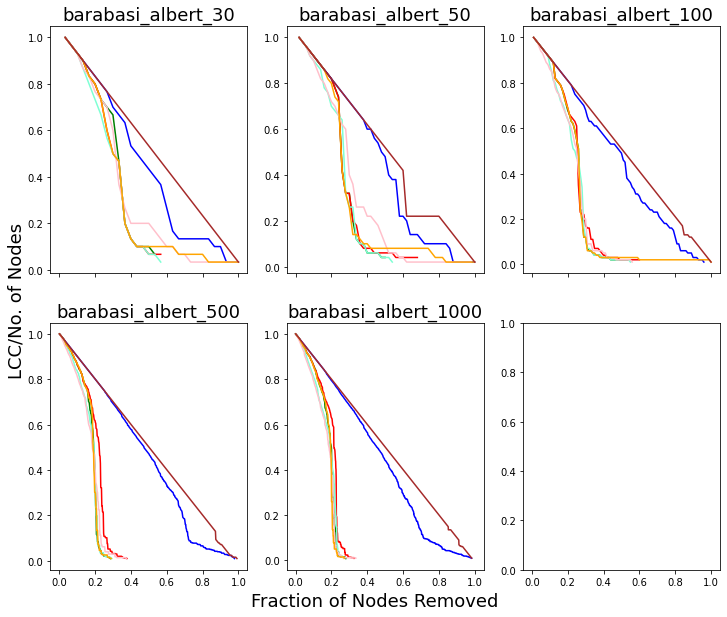

In [2]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 295500
MIX = 212500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
#attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/model_differentGraph_'+str(MIX))]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['barabasi_albert_30','barabasi_albert_50','barabasi_albert_100','barabasi_albert_500','barabasi_albert_1000']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"ba",[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]],[2,3])


## ER Graph

erdos_renyi_30 ,[11, 14, 7, 23, 15, 19, 20, 2, 6, 9, 4, 12, 24, 21]
[11, 23, 7, 15, 19, 6, 14, 20, 2, 9, 24, 3, 16, 26, 0, 4]
[13, 23, 26, 14, 6, 12, 15, 22, 18, 17, 29, 19, 0, 1, 27, 25, 7]
[23, 13, 18, 14, 28, 6, 26, 29, 27, 12, 24, 1, 15, 21, 20, 10, 22, 3, 17, 16, 0, 25, 5, 19, 7, 2, 4, 11, 8]
[6, 12, 23, 14, 26, 15, 13, 1, 18, 27, 19, 0, 20, 11, 22, 2, 3, 4, 29, 5, 7, 8, 9, 28, 10, 16, 25, 17, 24, 21]
[7, 11, 14, 15, 23, 19, 20, 6, 12, 3, 4, 13, 26, 2, 21, 24, 28, 22, 10, 9, 29, 27, 16, 1, 17, 8, 0, 18, 25, 5]
[6, 12, 10, 23, 20, 9, 2, 4, 26, 7, 21, 28, 8, 22, 1, 24, 19, 25, 18, 14, 16, 13, 5, 11, 15, 29]
erdos_renyi_50 ,[19, 18, 29, 13, 9, 10, 42, 3, 27, 30, 20, 5, 11, 15, 41, 4, 36, 45, 2, 6, 40, 16, 21, 1, 32, 35, 28, 25, 24]
[19, 18, 29, 13, 9, 10, 42, 3, 27, 15, 20, 5, 33, 16, 37, 4, 36, 6, 30, 25, 2, 22, 1, 11, 39, 23, 40, 47, 44, 35, 14, 26, 7, 12]
[27, 34, 24, 9, 4, 30, 13, 29, 42, 15, 7, 44, 6, 45, 33, 35, 2, 12, 17, 37, 21, 43, 41, 26, 25, 38, 31, 49, 1, 16]
[34, 24, 27,

[229, 336, 116, 96, 199, 115, 197, 226, 422, 70, 66, 252, 326, 92, 236, 317, 71, 411, 357, 404, 370, 30, 15, 7, 61, 139, 26, 45, 487, 119, 124, 117, 44, 129, 283, 488, 389, 210, 201, 386, 19, 279, 220, 183, 402, 177, 103, 434, 344, 131, 297, 480, 246, 275, 466, 289, 52, 316, 381, 127, 441, 159, 164, 378, 264, 428, 51, 358, 133, 168, 351, 134, 491, 492, 14, 34, 170, 31, 383, 373, 120, 57, 306, 478, 285, 156, 17, 311, 49, 414, 46, 24, 455, 335, 207, 174, 171, 290, 477, 137, 40, 248, 328, 391, 324, 125, 146, 230, 485, 333, 84, 327, 36, 104, 157, 110, 320, 384, 0, 251, 107, 495, 366, 22, 185, 432, 228, 460, 332, 222, 121, 483, 74, 39, 278, 293, 319, 299, 343, 348, 175, 81, 493, 244, 153, 400, 176, 128, 458, 475, 151, 407, 292, 309, 437, 105, 423, 95, 462, 450, 16, 418, 32, 155, 55, 260, 361, 447, 350, 390, 443, 284, 372, 205, 341, 172, 72, 271, 239, 294, 435, 362, 364, 464, 8, 303, 256, 180, 436, 160, 100, 325, 148, 291, 353, 494, 53, 41, 135, 471, 216, 268, 97, 499, 227, 474, 287, 481, 88

[229, 116, 336, 197, 115, 422, 199, 70, 96, 66, 226, 252, 326, 92, 236, 317, 487, 370, 411, 357, 15, 404, 119, 7, 61, 26, 351, 45, 124, 129, 44, 389, 71, 210, 289, 283, 183, 168, 275, 488, 164, 402, 177, 220, 344, 30, 139, 386, 19, 297, 117, 264, 103, 127, 466, 52, 434, 378, 279, 316, 383, 358, 159, 491, 492, 32, 133, 428, 51, 441, 335, 480, 120, 414, 14, 373, 17, 34, 107, 476, 156, 285, 478, 381, 207, 36, 46, 84, 40, 146, 477, 171, 137, 24, 311, 324, 248, 125, 134, 153, 170, 131, 290, 455, 157, 391, 251, 230, 31, 97, 291, 174, 205, 485, 457, 493, 446, 88, 495, 418, 105, 320, 104, 135, 22, 436, 299, 499, 292, 222, 432, 327, 460, 458, 348, 284, 172, 228, 384, 333, 483, 39, 74, 121, 95, 343, 246, 55, 244, 319, 72, 151, 260, 303, 278, 185, 400, 437, 110, 232, 57, 293, 390, 41, 58, 353, 464, 364, 81, 443, 216, 53, 68, 294, 328, 49, 176, 471, 3, 8, 475, 0, 239, 100, 361, 148, 462, 128, 201, 407, 268, 372, 332, 309, 362, 415, 395, 256, 175, 243, 366, 253, 325, 196, 162, 482, 417, 341, 342, 4

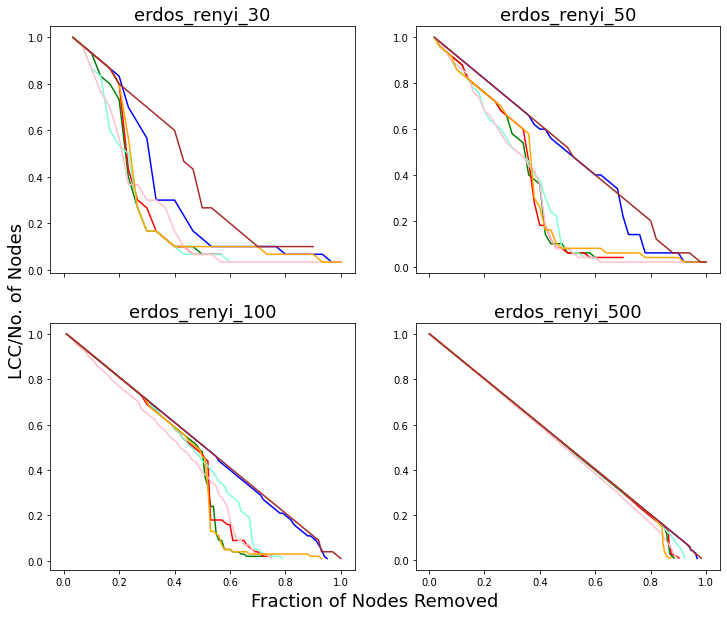

In [3]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 295500
MIX = 212500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
#attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/model_differentGraph_'+str(MIX))]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['erdos_renyi_30','erdos_renyi_50','erdos_renyi_100','erdos_renyi_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"er",[[0,0],[0,1],[1,0],[1,1]],[2,2])


## SW Graph

small-world_30 ,[20, 4, 8, 12, 19, 1, 14, 2, 24, 16, 26, 3, 5, 10, 7, 23, 15]
[20, 4, 8, 12, 19, 1, 14, 2, 24, 16, 26, 3, 13, 6, 21, 28, 22, 17]
[29, 26, 2, 8, 5, 24, 22, 10, 19, 15, 11, 17, 3, 28, 12, 23, 16, 4, 7, 21]
[5, 9, 8, 24, 25, 22, 12, 15, 19, 18, 11, 21, 3, 2, 29, 28, 26, 6, 10, 27, 1, 7, 14, 23, 17, 13, 16, 20, 4]
[8, 5, 19, 24, 15, 28, 10, 2, 25, 29, 11, 22, 3, 0, 1, 4, 6, 7, 14, 9, 12, 21, 13, 16, 17, 18, 20, 23, 26, 27]
[8, 4, 20, 19, 12, 17, 26, 0, 1, 24, 14, 2, 16, 13, 28, 15, 6, 3, 18, 9, 11, 7, 5, 22, 25, 29, 23, 27, 21, 10]
[19, 5, 15, 14, 16, 18, 17, 10, 24, 28, 2, 8, 0, 6, 7, 9, 4, 3, 1, 29, 27, 26, 25, 23, 13, 12, 11, 22, 21, 20]
small-world_50 ,[33, 38, 11, 22, 8, 28, 21, 34, 37, 6, 46, 17, 13, 0, 24, 44, 12, 48, 20, 36, 29, 3, 31, 42, 16, 26, 43, 49, 2, 1]
[33, 38, 6, 22, 11, 28, 42, 8, 36, 18, 44, 34, 13, 40, 27, 0, 17, 46, 19, 24, 12, 3, 37, 29, 43, 47, 20, 31, 7, 2, 1, 15, 48]
[7, 4, 0, 47, 31, 46, 44, 41, 8, 11, 12, 28, 27, 22, 15, 21, 18, 34, 37, 38, 17, 3

[39, 79, 368, 170, 422, 243, 152, 430, 176, 165, 141, 126, 261, 240, 218, 356, 322, 32, 227, 178, 103, 203, 438, 130, 384, 64, 391, 172, 197, 231, 292, 189, 38, 34, 489, 389, 487, 344, 244, 22, 24, 27, 363, 52, 373, 56, 21, 41, 105, 26, 482, 133, 343, 181, 174, 217, 145, 125, 65, 251, 230, 260, 321, 199, 330, 367, 494, 479, 215, 202, 461, 163, 8, 101, 319, 67, 457, 297, 54, 286, 167, 311, 317, 2, 87, 90, 93, 345, 94, 30, 48, 355, 237, 377, 192, 188, 137, 18, 204, 211, 5, 429, 253, 254, 498, 486, 312, 302, 127, 164, 259, 442, 300, 160, 425, 102, 439, 394, 433, 233, 150, 285, 267, 314, 298, 360, 70, 60, 109, 305, 411, 412, 77, 332, 58, 421, 470, 146, 248, 291, 416, 472, 423, 476, 11, 120, 283, 441, 455, 177, 4, 59, 71, 73, 76, 107, 108, 115, 117, 118, 119, 182, 194, 279, 280, 282, 303, 304, 339, 397, 399, 400, 401, 402, 403, 409, 410, 413, 419, 35, 69, 169, 238, 274, 418, 471, 139, 49, 328, 364, 140, 156, 185, 273, 406, 249, 467, 436, 29, 83, 325, 463, 72, 74, 75, 110, 111, 112, 113, 114

[538, 524, 527, 67, 579, 258, 53, 40, 984, 221, 37, 66, 384, 361, 780, 385, 365, 200, 180, 203, 190, 166, 800, 732, 749, 746, 249, 489, 914, 730, 207, 988, 829, 807, 888, 814, 794, 795, 787, 697, 479, 491, 141, 427, 906, 502, 431, 322, 457, 392, 947, 953, 950, 232, 948, 413, 418, 856, 879, 412, 359, 937, 145, 777, 910, 934, 444, 403, 894, 393, 878, 867, 10, 859, 875, 864, 860, 750, 835, 756, 850, 281, 307, 101, 83, 727, 597, 358, 774, 788, 5, 211, 791, 225, 290, 718, 352, 98, 833, 210, 432, 426, 570, 105, 266, 715, 848, 147, 148, 327, 134, 978, 534, 87, 315, 126, 675, 659, 678, 847, 633, 116, 345, 95, 637, 966, 655, 586, 511, 84, 535, 552, 547, 160, 17, 21, 304, 447, 434, 925, 531, 994, 714, 272, 274, 278, 77, 612, 626, 623, 240, 128, 763, 764, 291, 313, 310, 330, 977, 938, 964, 963, 720, 512, 646, 645, 752, 887, 374, 375, 492, 561, 562, 658, 690, 687, 466, 465, 342, 339, 571, 3, 18, 401, 125, 590, 587, 622, 907, 222, 767, 231, 75, 613, 897, 898, 443, 50, 49, 817, 818, 503, 29, 30, 738

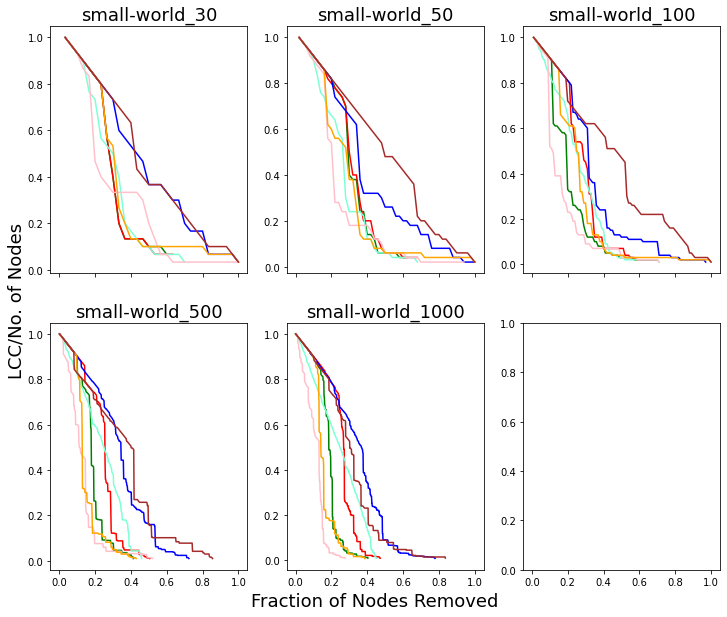

In [4]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 295500
MIX = 212500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
#attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/model_differentGraph_'+str(MIX))]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['small-world_30','small-world_50','small-world_100','small-world_500','small-world_1000']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"sw",[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]],[2,3])


# Synthetic with Motifs Attached

## BA

ba_300_20_house_1 ,[8, 6, 3, 10, 1, 7, 42, 0, 104, 9, 44, 2, 105, 5, 46, 103, 267, 107, 85, 143, 166, 108, 57, 12, 13, 4, 294, 51, 193, 205, 11, 219, 119, 112, 106, 110, 16, 248, 43, 218, 49, 303, 52, 114, 169, 164, 281, 60, 22, 56, 14, 87, 192, 61, 222, 245, 300, 177, 86, 275, 167, 191, 274, 288, 252, 54, 153, 286, 50, 307, 58, 146, 97, 63, 17, 254, 59, 53, 93, 260, 136, 122, 195, 156, 96, 66, 109, 229, 173, 95, 230, 236, 210, 175, 208, 26, 324, 145, 285, 249, 201, 72, 75, 326, 309, 314, 71, 321, 39, 157, 322, 310, 316, 305, 115, 315, 127, 15, 325, 69, 312, 376, 160, 111, 253, 224, 28, 217, 272, 296, 265, 302, 308, 318, 319, 320, 20, 90, 150, 121, 268, 25, 135, 247, 258, 29, 138, 116, 187, 377]
[8, 6, 3, 10, 1, 7, 42, 0, 104, 9, 44, 2, 105, 5, 46, 103, 267, 107, 143, 85, 166, 108, 57, 12, 13, 294, 77, 4, 119, 205, 193, 11, 219, 112, 51, 106, 110, 16, 248, 43, 218, 49, 303, 169, 114, 52, 164, 281, 60, 22, 56, 54, 87, 192, 61, 222, 177, 288, 300, 275, 274, 191, 86, 245, 95, 14, 252, 153

[0, 8, 7, 82, 6, 15, 122, 3, 12, 9, 5, 14, 1, 23, 24, 21, 127, 16, 18, 96, 10, 17, 20, 102, 263, 34, 11, 107, 123, 211, 106, 124, 213, 13, 223, 170, 148, 25, 204, 152, 19, 27, 187, 43, 212, 150, 103, 275, 28, 147, 234, 108, 151, 83, 89, 207, 254, 173, 113, 220, 228, 40, 278, 171, 36, 101, 133, 22, 279, 222, 131, 262, 84, 239, 242, 304, 243, 232, 47, 172, 163, 249, 214, 2, 158, 164, 85, 221, 121, 26, 54, 203, 128, 105, 146, 129, 69, 99, 336, 493, 197, 35, 59, 33, 316, 462, 457, 188, 72, 68, 199, 285, 98, 301, 227, 74, 67, 413, 117, 200, 475, 430, 330, 341, 337, 161, 391, 409, 488, 450, 338, 104, 343, 327, 332, 196, 134, 324, 328, 329, 340, 308, 428, 257, 115, 295, 162, 351, 132, 272, 41, 142, 236, 349, 241, 274, 288, 299, 182, 326, 302, 346, 305, 306, 309, 315, 318, 322, 323, 277, 250, 392, 410, 485, 345, 388, 191, 319, 264, 290, 286, 287, 97, 125, 137, 145, 49, 393, 226, 110, 75, 456, 109, 38, 331, 30, 268, 282, 4, 56, 400, 240, 81, 317, 325, 265, 165, 246, 216, 154, 354, 217, 57, 296,

ba_300_60_house_3 ,[6, 7, 2, 0, 8, 12, 4, 10, 1, 76, 9, 20, 77, 11, 14, 143, 56, 218, 118, 82, 61, 26, 81, 58, 183, 57, 17, 84, 209, 275, 79, 13, 156, 19, 155, 85, 187, 115, 184, 158, 129, 18, 90, 88, 192, 210, 219, 78, 308, 241, 96, 273, 254, 15, 157, 21, 295, 232, 152, 62, 246, 265, 16, 64, 119, 197, 5, 35, 54, 220, 163, 296, 259, 291, 289, 92, 87, 207, 191, 294, 225, 233, 80, 284, 248, 65, 211, 356, 271, 130, 298, 107, 30, 234, 135, 28, 164, 128, 293, 270, 343, 131, 282, 121, 327, 345, 226, 193, 594, 287, 334, 249, 29, 565, 319, 358, 145, 539, 314, 558, 338, 257, 337, 97, 69, 323, 361, 341, 306, 364, 350, 349, 360, 432, 325, 339, 322, 335, 348, 307, 269, 99, 329, 485, 261, 194, 318, 332, 355, 357, 359, 162, 98, 436, 105, 310, 352, 320, 150, 328, 344, 354, 398, 303, 300, 330, 53, 313, 326, 346, 317, 340, 312, 333, 230, 292, 342, 215, 251, 309, 321, 262, 279, 301, 302, 25, 59, 446, 173, 166, 288, 496, 297, 285]
[42, 48, 53, 28, 180, 29, 163, 100, 14, 199, 95, 112, 186, 6, 7, 2, 0, 8, 

ba_300_80_house_4 ,[0, 2, 5, 6, 10, 1, 9, 8, 12, 13, 19, 7, 162, 22, 260, 18, 20, 67, 14, 66, 139, 17, 23, 127, 15, 129, 209, 97, 26, 98, 101, 29, 11, 302, 141, 70, 3, 69, 31, 42, 199, 298, 163, 85, 16, 72, 80, 224, 79, 25, 27, 44, 24, 106, 21, 142, 38, 30, 28, 184, 198, 288, 235, 181, 193, 245, 39, 237, 33, 241, 103, 146, 100, 264, 211, 50, 99, 143, 226, 74, 71, 271, 115, 257, 240, 131, 120, 46, 132, 189, 247, 212, 35, 384, 191, 114, 253, 104, 208, 138, 151, 281, 140, 214, 164, 113, 52, 111, 504, 600, 344, 382, 387, 369, 496, 121, 243, 367, 229, 325, 389, 376, 312, 359, 380, 49, 128, 338, 335, 385, 379, 345, 352, 365, 388, 267, 371, 272, 283, 360, 340, 368, 374, 339, 218, 144, 584, 282, 333, 337, 372, 657, 61, 495, 172, 158, 152, 342, 355, 358, 362, 370, 200, 314, 363, 366, 378, 320, 324, 293, 180, 308, 332, 675, 65, 137, 207, 234, 252, 262, 287, 301, 303, 309, 315, 317, 321, 323, 326, 328, 329, 330, 336, 343, 346, 348, 349, 350, 351, 354, 357, 361, 375, 687, 377, 117, 201, 233, 423, 

[0, 2, 5, 12, 6, 11, 1, 9, 274, 22, 15, 24, 14, 8, 68, 27, 23, 16, 20, 10, 127, 7, 32, 92, 19, 230, 31, 30, 78, 134, 17, 33, 43, 39, 55, 63, 227, 58, 282, 13, 44, 122, 235, 221, 140, 26, 242, 54, 220, 47, 168, 175, 37, 3, 40, 224, 49, 45, 124, 18, 108, 294, 241, 104, 275, 61, 70, 266, 34, 214, 132, 59, 162, 36, 71, 25, 81, 165, 292, 252, 93, 116, 42, 243, 103, 84, 161, 76, 107, 94, 147, 121, 137, 64, 174, 60, 285, 238, 83, 203, 89, 98, 67, 253, 86, 91, 269, 131, 205, 129, 273, 250, 136, 41, 226, 38, 257, 119, 53, 223, 160, 247, 114, 280, 194, 236, 75, 167, 255, 74, 48, 97, 196, 248, 123, 115, 207, 265, 271, 166, 202, 290, 670, 674, 671, 673, 672, 141, 153, 56, 212, 259, 145, 198, 112, 260, 182, 605, 609, 608, 607, 606, 385, 388, 387, 386, 389, 155, 233, 144, 152, 245, 99, 51, 169, 283, 204, 244, 219, 436, 437, 439, 435, 438, 650, 653, 210, 652, 158, 654, 651, 146, 101, 299, 600, 180, 604, 246, 603, 601, 199, 190, 249, 602, 500, 504, 503, 120, 502, 501, 52, 143, 510, 513, 512, 514, 511,

[111, 363, 88, 236, 42, 114, 83, 306, 380, 199, 166, 248, 23, 342, 231, 275, 75, 65, 150, 340, 388, 196, 254, 173, 28, 389, 228, 332, 126, 364, 170, 152, 92, 128, 242, 174, 386, 224, 210, 125, 180, 32, 54, 351, 29, 190, 127, 201, 118, 130, 154, 146, 393, 168, 218, 94, 273, 240, 177, 280, 247, 182, 2, 110, 30, 246, 373, 89, 408, 57, 74, 329, 39, 207, 303, 96, 232, 347, 397, 143, 405, 33, 189, 169, 106, 20, 355, 123, 67, 73, 47, 262, 233, 52, 179, 41, 66, 249, 404, 21, 383, 378, 104, 40, 295, 38, 157, 69, 281, 191, 132, 323, 221, 200, 45, 245, 129, 225, 44, 145, 158, 260, 294, 183, 327, 220, 357, 377, 101, 22, 197, 317, 269, 202, 167, 141, 147, 90, 301, 227, 70, 300, 34, 250, 15, 206, 256, 297, 165, 257, 406, 102, 24, 283, 356, 212, 285, 124, 610, 322, 288, 159, 346, 109, 229, 310, 108, 366, 61, 255, 84, 403, 137, 139, 78, 133, 335, 162, 222, 296, 26, 131, 98, 68, 396, 144, 274, 223, 209, 136, 181, 115, 241, 259, 36, 48, 85, 234, 630, 646, 700, 748, 788, 237, 660, 171, 261, 81, 226, 176,

[0, 6, 3, 7, 17, 10, 20, 1, 26, 8, 11, 12, 13, 29, 9, 21, 31, 5, 45, 14, 28, 58, 16, 4, 2, 33, 50, 23, 74, 25, 105, 18, 43, 61, 15, 102, 42, 32, 53, 27, 169, 34, 106, 130, 175, 44, 41, 94, 39, 84, 178, 134, 209, 124, 162, 156, 138, 24, 252, 103, 131, 48, 30, 240, 183, 92, 36, 67, 81, 75, 228, 108, 190, 109, 37, 248, 52, 111, 149, 60, 55, 265, 167, 195, 222, 118, 186, 180, 54, 174, 49, 38, 97, 294, 143, 68, 86, 221, 133, 88, 250, 148, 161, 150, 126, 77, 69, 263, 123, 95, 116, 141, 168, 200, 203, 22, 160, 121, 107, 275, 171, 72, 159, 46, 135, 152, 119, 85, 179, 87, 246, 216, 89, 144, 210, 71, 229, 238, 57, 35, 244, 271, 82, 59, 79, 99, 101, 117, 128, 137, 147, 172, 173, 189, 193, 206, 219, 225, 257]
[145, 73, 18, 11, 71, 5, 134, 12, 109, 152, 9, 67, 2, 105, 94, 125, 10, 24, 15, 106, 69, 22, 211, 265, 23, 165, 27, 8, 17, 4, 95, 29, 32, 189, 156, 153, 260, 74, 1, 88, 70, 160, 284, 295, 39, 197, 161, 230, 159, 38, 229, 97, 280, 293, 41, 232, 193, 87, 303, 219, 112, 149, 19, 68, 114, 286, 82

[8, 1, 7, 0, 20, 6, 10, 12, 45, 2, 3, 18, 44, 60, 25, 48, 37, 135, 28, 17, 105, 59, 42, 267, 13, 11, 22, 36, 87, 24, 98, 9, 65, 123, 256, 34, 140, 166, 27, 160, 50, 330, 14, 94, 90, 5, 227, 71, 30, 273, 39, 35, 165, 76, 173, 55, 106, 124, 115, 293, 119, 219, 120, 157, 92, 275, 23, 102, 133, 272, 232, 121, 261, 32, 143, 54, 182, 137, 43, 53, 64, 280, 89, 19, 85, 271, 52, 180, 192, 116, 56, 222, 33, 127, 224, 285, 258, 63, 292, 228, 86, 212, 51, 80, 77, 15, 220, 101, 184, 150, 57, 138, 263, 73, 231, 99, 257, 282, 117, 296, 148, 240, 130, 29, 323, 177, 215, 125, 186, 249, 270, 82, 16, 142, 288, 169, 155, 175, 178, 134, 145, 247, 107, 69, 62, 111, 122, 236, 21, 229, 205, 217, 237, 126, 284, 225, 88, 176, 294, 243, 297, 242, 171, 174, 156, 226, 78, 96, 38, 61, 259, 141, 266, 170, 183, 203, 132, 91, 189, 41, 163, 207, 81, 68, 234, 218, 204, 223, 66, 279, 152, 83, 216, 253, 72, 265, 299, 100, 210, 239, 200, 268, 264, 75, 251, 255, 298, 74, 260, 139, 84, 197, 269, 128, 208, 110, 287, 93, 250, 

[6, 0, 9, 7, 8, 5, 2, 12, 28, 3, 14, 1, 10, 4, 86, 87, 19, 17, 89, 68, 67, 23, 131, 191, 88, 15, 217, 243, 91, 165, 265, 130, 161, 26, 92, 22, 147, 74, 110, 220, 30, 207, 36, 25, 95, 16, 11, 98, 118, 112, 20, 193, 246, 70, 290, 162, 49, 157, 53, 32, 303, 213, 144, 116, 150, 336, 133, 43, 155, 308, 319, 377, 170, 29, 309, 39, 120, 171, 173, 212, 264, 137, 172, 200, 286, 99, 69, 40, 33, 101, 106, 119, 82, 46, 280, 359, 218, 372, 136, 208, 84, 211, 271, 174, 296, 192, 332, 114, 194, 346, 65, 42, 273, 134, 210, 38, 62, 56, 234, 111, 242, 270, 181, 235, 138, 24, 185, 85, 209, 156, 314, 81, 100, 261, 250, 125, 153, 354, 228, 35, 239, 75, 83, 18, 262, 260, 140, 163, 263, 340, 21, 248, 266, 175, 143, 107, 216, 375, 169, 55, 47, 63, 295, 328, 50, 267, 122, 368, 237, 104, 240, 247, 292, 320, 52, 132, 255, 73, 166, 93, 60, 77, 117, 152, 201, 301, 31, 71]
[6, 0, 9, 7, 8, 2, 5, 13, 45, 3, 16, 10, 1, 14, 4, 61, 19, 29, 39, 27, 63, 213, 24, 48, 12, 21, 68, 46, 22, 42, 15, 111, 123, 177, 34, 87, 26, 5

[36, 99, 18, 30, 24, 84, 6, 27, 261, 168, 51, 93, 56, 21, 66, 135, 39, 72, 9, 15, 12, 114, 246, 14, 10, 0, 118, 146, 96, 25, 29, 90, 48, 26, 17, 28, 5, 22, 16, 2, 91, 23, 32, 8, 150, 13, 20, 50, 177, 94, 37, 101, 276, 110, 65, 88, 11, 92, 7, 3, 63, 75, 132, 159, 70, 160, 1, 163, 33, 102, 123, 40, 191, 98, 49, 124, 46, 108, 68, 125, 183, 186, 200, 111, 79, 148, 82, 126, 58, 42, 62, 162, 38, 83, 128, 89, 4, 240, 80, 35, 43, 34, 149, 31, 190, 227, 77, 158, 57, 181, 204, 251, 44, 188, 19, 243, 234, 172, 153, 127, 273, 165, 180, 255, 228, 105, 120, 274, 59, 71, 248, 106, 237, 293, 358, 210, 145, 272, 278, 280, 291, 218, 195, 115, 267, 249, 117, 197, 295, 279, 69, 297, 289, 268, 265, 220, 213, 192, 47, 292, 112, 253, 231, 236, 219, 54, 352, 161, 281, 164, 266, 212, 151]
[8, 0, 6, 10, 9, 7, 14, 15, 12, 16, 21, 24, 18, 13, 22, 36, 25, 30, 2, 1, 20, 27, 17, 28, 38, 29, 99, 40, 5, 56, 26, 84, 32, 88, 3, 72, 66, 91, 39, 47, 110, 98, 37, 34, 63, 11, 70, 75, 79, 50, 128, 163, 118, 65, 77, 23, 148, 

[7, 0, 10, 12, 6, 14, 3, 27, 4, 136, 9, 2, 17, 11, 15, 293, 24, 206, 16, 21, 34, 40, 13, 249, 18, 243, 300, 33, 23, 22, 69, 169, 98, 1, 119, 278, 19, 61, 106, 32, 5, 265, 26, 75, 123, 51, 268, 276, 237, 227, 218, 173, 182, 78, 59, 294, 38, 58, 63, 107, 252, 42, 288, 52, 128, 93, 144, 161, 148, 277, 44, 117, 143, 36, 122, 86, 291, 211, 239, 244, 212, 73, 8, 233, 48, 286, 273, 142, 62, 162, 158, 134, 210, 39, 266, 108, 215, 46, 56, 20, 130, 183, 292, 194, 284, 235, 25, 113, 83, 159, 79, 289, 174, 217, 275, 55, 178, 149, 118, 152, 164, 129, 47, 60, 114, 135, 138, 238, 255, 147, 124, 50, 121, 274, 137, 57, 91, 125, 299, 109, 116, 187, 270, 260, 76, 240, 257, 29, 80, 166, 219, 37, 228, 231, 225, 30, 71, 68, 100, 53, 175, 283, 250, 111, 263, 180, 156, 65, 67, 74, 191, 115, 84, 94, 95, 150, 251, 155, 256, 280, 35, 97, 192, 172, 216, 170, 213, 248, 214, 104, 96, 168, 259, 279, 72, 70, 139, 202, 54, 120, 160, 207, 141, 230, 226, 185, 246, 101, 153, 208, 41, 298, 64, 49, 176, 154, 66, 195, 77, 2

[8, 10, 53, 0, 100, 12, 6, 4, 9, 13, 76, 7, 194, 1, 24, 54, 18, 282, 16, 19, 56, 196, 166, 3, 11, 126, 264, 135, 5, 243, 2, 105, 266, 21, 274, 155, 14, 195, 101, 140, 226, 167, 79, 121, 209, 55, 17, 200, 267, 93, 137, 20, 184, 242, 157, 219, 37, 275, 180, 220, 61, 15, 31, 85, 170, 169, 136, 162, 108, 294, 80, 95, 284, 125, 172, 112, 131, 202, 186, 176, 91, 293, 177, 260, 179, 163, 26, 144, 87, 281, 164, 27, 63, 29, 146, 97, 212, 236, 198, 83, 28, 110, 296, 147, 51, 283, 185, 249, 62, 43, 103, 154, 25, 261, 235, 145, 174, 300, 290, 40, 124, 74, 92, 175, 153, 262, 114, 206, 75, 59, 69, 66, 41, 116, 115, 77, 205, 57, 204, 199, 132, 197, 117, 245, 234, 82, 120, 286, 99, 276, 191, 36, 168, 278, 130, 158, 224, 233, 287, 102, 298, 23, 215, 52, 84, 299, 268, 94]
[8, 10, 300, 12, 13, 0, 6, 4, 9, 18, 14, 7, 1, 25, 47, 70, 15, 27, 34, 28, 23, 75, 92, 77, 33, 37, 42, 88, 84, 24, 31, 11, 60, 61, 206, 132, 97, 32, 150, 224, 168, 197, 51, 52, 16, 40, 238, 80, 68, 100, 74, 175, 79, 182, 43, 5, 45, 111

[300, 0, 2, 10, 7, 9, 6, 11, 16, 8, 14, 22, 4, 23, 39, 57, 20, 12, 21, 3, 45, 29, 1, 27, 50, 5, 26, 36, 59, 25, 33, 103, 28, 38, 37, 30, 54, 15, 55, 84, 81, 51, 52, 92, 47, 40, 95, 31, 24, 74, 102, 60, 210, 90, 120, 94, 178, 61, 100, 179, 88, 139, 181, 76, 13, 68, 240, 64, 86, 248, 115, 35, 164, 174, 19, 44, 209, 32, 91, 48, 143, 147, 127, 246, 212, 53, 156, 34, 132, 170, 213, 65, 163, 190, 71, 80, 73, 123, 118, 122, 144, 214, 87, 72, 96, 114, 250, 269, 131, 161, 236, 99, 205, 66, 206, 105, 232, 275, 187, 129, 17, 108, 43, 273, 49, 243, 18, 165, 265, 202, 194, 183, 70, 116, 157, 172, 279, 289, 238, 149, 152, 98, 113, 136, 168, 182, 201, 217, 222, 247, 263, 268, 287, 288, 291]
[254, 1, 115, 61, 126, 80, 18, 75, 16, 129, 5, 164, 11, 4, 142, 13, 128, 17, 185, 203, 252, 20, 81, 204, 76, 19, 143, 216, 118, 247, 166, 82, 10, 291, 3, 8, 26, 77, 30, 195, 92, 25, 228, 89, 127, 79, 84, 42, 21, 78, 233, 169, 276, 83, 299, 165, 158, 156, 236, 56, 88, 155, 23, 68, 27, 15, 235, 12, 241, 225, 32, 119

[300, 0, 6, 8, 4, 16, 7, 10, 12, 2, 22, 21, 14, 9, 18, 33, 25, 264, 19, 204, 20, 23, 277, 206, 226, 24, 3, 15, 98, 247, 233, 17, 29, 56, 69, 52, 60, 13, 34, 75, 49, 11, 39, 86, 176, 67, 70, 58, 83, 122, 185, 108, 76, 119, 68, 53, 103, 161, 196, 236, 91, 43, 110, 146, 44, 46, 55, 292, 199, 159, 72, 51, 125, 106, 31, 216, 145, 202, 155, 158, 214, 248, 26, 111, 82, 42, 294, 191, 37, 95, 254, 101, 148, 137, 274, 128, 130, 271, 61, 149, 131, 235, 182, 48, 88, 172, 65, 96, 278, 38, 73, 265, 94, 255, 169, 152, 27, 113, 280, 286, 59, 156, 283, 262, 171, 92, 168, 223, 201, 63, 138, 136, 290, 279, 57, 249, 132, 41, 213, 267, 144, 117, 84, 129, 242, 293, 112, 78, 143, 194, 97, 163, 297, 71, 80, 229, 32, 45, 221, 252, 259, 150, 79, 198, 81, 30, 109, 1, 270, 47, 188, 218, 50, 207, 257, 116, 157, 273, 177, 230, 284, 258, 164, 35, 222, 251, 275, 268, 74, 90, 85, 276, 192, 175, 93, 208, 296, 266, 250, 142, 260, 215, 219, 197, 299, 282, 240, 256, 126, 183, 134, 64, 28, 118, 193, 123, 127, 209, 190, 36,

[6, 2, 9, 0, 5, 20, 8, 29, 249, 11, 7, 10, 16, 22, 70, 44, 39, 13, 25, 60, 103, 32, 169, 36, 21, 18, 156, 31, 30, 1, 87, 12, 38, 79, 54, 57, 75, 77, 42, 159, 140, 64, 53, 149, 52, 46, 59, 121, 35, 266, 3, 124, 105, 19, 123, 227, 24, 254, 289, 74, 15, 50, 37, 104, 154, 26, 62, 165, 73, 163, 276, 17, 186, 191, 197, 106, 71, 275, 253, 288, 61, 68, 221, 138, 45, 211, 170, 43, 207, 41, 267, 84, 281, 212, 126, 144, 180, 260, 239, 157, 125, 226, 63, 113, 284, 241, 55, 179, 271, 4, 89, 258, 177, 261, 270, 112, 111, 192, 95, 230, 280, 402, 255, 34, 223, 158, 176, 209, 110, 127, 246, 208, 235, 153, 285, 291, 194, 100, 48, 161, 107, 47, 198, 233, 175, 399, 370, 234, 28, 94, 122, 273, 228, 264, 65, 206, 251, 152, 204, 201, 296, 93, 86, 298, 174, 348, 384, 360, 76, 189, 277, 229, 92, 243, 27, 336, 383, 72, 283, 354, 115, 178, 248, 220, 219, 193, 268, 390, 362, 322, 324, 316, 415, 413, 347, 377, 331, 82, 129, 257, 134, 217, 286, 203, 108, 185, 181, 237, 247, 147, 56, 150, 308, 326, 333, 323, 382, 41

[0, 6, 18, 11, 1, 14, 13, 2, 12, 4, 9, 7, 150, 10, 31, 15, 82, 35, 23, 16, 299, 43, 45, 46, 8, 187, 53, 42, 22, 26, 104, 229, 56, 159, 29, 34, 52, 27, 41, 99, 133, 91, 37, 166, 218, 283, 50, 79, 5, 258, 19, 90, 121, 32, 25, 36, 48, 71, 76, 17, 298, 158, 294, 80, 249, 275, 100, 185, 60, 55, 70, 197, 73, 206, 152, 242, 176, 47, 30, 251, 127, 98, 62, 69, 178, 162, 33, 199, 96, 196, 280, 255, 224, 65, 160, 51, 57, 103, 193, 38, 122, 225, 471, 163, 184, 282, 105, 114, 113, 95, 232, 101, 135, 24, 124, 179, 222, 173, 126, 262, 68, 108, 198, 155, 92, 233, 81, 93, 58, 21, 263, 204, 142, 480, 210, 524, 435, 324, 522, 539, 528, 422, 420, 181, 191, 94, 44, 281, 438, 450, 175, 292, 147, 89, 290, 112, 230, 257, 271, 157, 212, 194, 248, 220, 234, 39, 260, 429, 378, 116, 205, 136, 276, 223, 243, 115, 125, 149, 64, 129, 63, 498, 486, 217, 402, 462, 189, 366, 504, 238, 132, 444, 372, 510, 342, 49, 265, 272, 211, 214, 474, 456, 516, 252, 318, 310, 170, 259, 72, 365, 433, 495, 333, 317, 311, 400, 386, 493

[396, 401, 506, 520, 534, 579, 593, 640, 430, 137, 66, 316, 206, 275, 250, 422, 514, 566, 576, 595, 630, 531, 541, 405, 408, 414, 418, 429, 437, 439, 470, 482, 484, 495, 505, 637, 638, 648, 491, 164, 105, 33, 128, 247, 246, 207, 433, 158, 20, 97, 165, 73, 272, 71, 130, 26, 39, 98, 189, 41, 166, 224, 159, 387, 498, 30, 29, 297, 106, 129, 353, 76, 19, 132, 40, 100, 421, 515, 525, 544, 559, 569, 598, 611, 635, 645, 659, 382, 500, 508, 231, 184, 367, 343, 110, 25, 4, 333, 233, 360, 289, 309, 109, 27, 589, 609, 31, 44, 138, 335, 157, 144, 217, 127, 142, 17, 215, 171, 154, 259, 74, 45, 286, 191, 195, 202, 187, 346, 277, 239, 95, 92, 338, 358, 241, 332, 230, 139, 72, 149, 269, 13, 93, 391, 339, 347, 365, 89, 94, 356, 280, 102, 78, 11, 205, 103, 240, 151, 245, 305, 284, 112, 348, 16, 37, 36, 398, 400, 459, 460, 492, 493, 545, 546, 547, 565, 585, 617, 619, 620, 627, 641, 643, 644, 649, 104, 15, 96, 141, 296, 262, 84, 80, 153, 123, 113, 263, 222, 77, 220, 278, 232, 58, 355, 397, 533, 636, 639, 2

[6, 0, 7, 4, 8, 18, 11, 27, 22, 17, 5, 51, 52, 15, 21, 10, 71, 9, 25, 19, 28, 33, 26, 43, 48, 3, 14, 37, 58, 50, 113, 75, 201, 100, 46, 221, 271, 78, 124, 199, 182, 2, 210, 186, 189, 96, 36, 131, 16, 207, 39, 38, 175, 296, 274, 97, 49, 166, 194, 23, 690, 240, 1, 95, 138, 272, 53, 72, 92, 692, 732, 694, 130, 139, 115, 238, 41, 408, 228, 125, 276, 251, 30, 126, 162, 89, 98, 410, 60, 88, 42, 177, 204, 229, 110, 80, 117, 211, 173, 112, 257, 32, 214, 292, 104, 191, 192, 108, 287, 144, 273, 254, 143, 35, 153, 159, 47, 93, 196, 103, 774, 31, 29, 90, 726, 105, 438, 498, 94, 259, 66, 776, 295, 24, 64, 65, 81, 82, 156, 122, 361, 73, 102, 129, 141, 269, 59, 135, 222, 219, 172, 553, 567, 12, 468, 198, 474, 414, 642, 260, 185, 648, 247, 476, 416, 555, 440, 500, 522, 750, 470, 650, 363, 45, 666, 524, 752, 236, 630, 528, 673, 426, 546, 540, 428, 530, 675, 632, 762, 764, 548, 367, 768, 668, 565, 600, 594, 644, 770, 369, 728, 636, 542, 545, 638, 684, 734, 596, 602, 564, 733, 599, 605, 397, 686, 688]
[6

ba_300_100_diamond_5 ,[0, 6, 63, 187, 9, 144, 1, 13, 64, 96, 11, 2, 3, 16, 10, 4, 8, 223, 72, 7, 19, 17, 217, 5, 117, 252, 15, 238, 22, 69, 73, 12, 309, 148, 119, 66, 152, 240, 253, 178, 153, 14, 97, 162, 228, 120, 74, 132, 78, 204, 254, 154, 274, 23, 28, 118, 201, 197, 155, 68, 218, 255, 18, 30, 209, 200, 121, 98, 199, 43, 286, 41, 276, 247, 135, 79, 320, 293, 183, 37, 205, 764, 107, 32, 581, 83, 188, 169, 161, 136, 883, 81, 85, 207, 184, 256, 355, 873, 202, 379, 893, 664, 851, 402, 515, 300, 648, 461, 437, 470, 363, 684, 852, 109, 871, 675, 147, 891, 784, 87, 206, 191, 334, 443, 498, 651, 769, 667, 894, 767, 182, 518, 250, 665, 892, 788, 798, 672, 196, 133, 372, 853, 272, 395, 406, 42, 777, 348, 193, 878, 314, 259, 268, 112, 233, 850, 508, 444, 347, 408, 39, 84, 301, 350, 346, 367, 172, 25, 387, 887, 392, 312, 305, 115, 122, 208, 170, 339, 95, 82, 264, 131, 460, 315, 324, 325, 331, 141, 340, 354, 358, 366, 368, 369, 371, 375, 376, 377, 383, 385, 388, 389, 390, 391, 393, 127, 304, 396

[259, 463, 468, 596, 630, 734, 668, 788, 277, 667, 209, 549, 594, 597, 707, 736, 418, 450, 455, 477, 479, 485, 515, 519, 532, 542, 548, 561, 566, 568, 571, 588, 598, 599, 605, 607, 629, 636, 639, 641, 643, 700, 701, 706, 717, 727, 730, 742, 768, 775, 796, 802, 811, 814, 816, 817, 843, 844, 860, 865, 877, 897, 119, 253, 460, 274, 400, 309, 178, 379, 37, 238, 518, 118, 355, 388, 228, 254, 255, 665, 152, 15, 237, 199, 79, 19, 162, 416, 443, 483, 498, 503, 533, 543, 552, 557, 572, 610, 635, 640, 656, 681, 704, 709, 714, 719, 754, 777, 793, 803, 850, 858, 863, 878, 883, 899, 28, 201, 406, 148, 322, 674, 688, 689, 889, 424, 664, 666, 670, 765, 771, 871, 240, 402, 18, 365, 135, 394, 68, 84, 70, 182, 120, 293, 578, 22, 372, 97, 324, 191, 205, 186, 34, 85, 153, 74, 30, 87, 158, 344, 269, 208, 345, 177, 183, 73, 348, 361, 374, 69, 223, 300, 306, 286, 359, 78, 136, 276, 17, 233, 134, 155, 245, 23, 442, 350, 389, 154, 362, 43, 651, 317, 244, 332, 261, 271, 367, 260, 66, 107, 371, 62, 232, 884, 112

[8, 3, 2, 16, 19, 6, 0, 9, 7, 1, 15, 14, 17, 12, 13, 44, 4, 24, 47, 37, 60, 67, 34, 10, 28, 22, 27, 26, 35, 153, 30, 92, 49, 80, 63, 62, 39, 33, 65, 102, 32, 25, 145, 40, 167, 121, 18, 53, 11, 144, 41, 42, 20, 168, 54, 160, 73, 151, 136, 70, 118, 43, 61, 165, 227, 64, 133, 93, 85, 176, 87, 109, 104, 202, 114, 48, 84, 50, 55, 203, 240, 172, 244, 21, 68, 76, 239, 141, 66, 139, 94, 123, 159, 111, 135, 110, 115, 209, 45, 222, 174, 36, 271, 120, 52, 189, 91, 207, 294, 198, 195, 279, 106, 241, 137, 82, 95, 185, 124, 119, 246, 200, 188, 259, 103, 79, 330, 69, 89, 72, 228, 180, 5, 88, 98, 204, 270, 96, 255, 56, 150, 193, 210, 285, 100, 157, 152, 29, 51, 59, 78, 113, 131, 143, 158, 162, 223, 231, 249, 253, 260, 289, 300, 75, 161, 164, 179, 205, 252, 254, 276, 296, 31, 46, 58, 74, 77, 117, 142]
[242, 15, 48, 12, 47, 50, 115, 8, 116, 180, 4, 118, 221, 11, 212, 46, 9, 182, 52, 17, 45, 76, 184, 78, 163, 34, 235, 54, 79, 122, 283, 234, 203, 254, 145, 20, 14, 230, 119, 53, 135, 55, 241, 146, 94, 110,

[6, 0, 1, 300, 8, 2, 9, 7, 10, 17, 307, 308, 23, 3, 11, 16, 13, 4, 42, 312, 311, 33, 22, 194, 26, 20, 21, 60, 275, 51, 317, 318, 12, 58, 32, 29, 258, 40, 14, 69, 122, 35, 231, 79, 271, 43, 50, 31, 131, 170, 24, 323, 71, 297, 322, 102, 260, 48, 121, 103, 19, 62, 353, 49, 108, 236, 64, 110, 44, 315, 316, 282, 45, 25, 115, 101, 330, 98, 328, 327, 93, 127, 227, 337, 226, 338, 46, 152, 223, 68, 248, 52, 124, 217, 137, 140, 287, 264, 39, 41, 90, 191, 216, 27, 86, 88, 277, 28, 298, 74, 128, 242, 265, 209, 193, 156, 83, 279, 181, 111, 208, 59, 85, 205, 294, 183, 47, 94, 281, 251, 166, 112, 99, 18, 151, 5, 220, 120, 72, 256, 113, 173, 357, 358, 230, 105, 292, 139, 175, 84, 324, 138, 155, 222, 237, 65, 202, 243, 153, 168, 348, 233, 367, 192, 368, 135, 210, 360, 218, 147, 195, 342, 354, 34, 92, 95, 81, 299, 160, 224, 290, 77, 125, 364, 363, 184, 239, 30, 134, 109, 143, 123, 91, 198, 249, 238, 104, 97, 197, 253, 235, 374, 259, 269, 180, 70, 55, 15, 261, 228, 241, 369, 149, 154, 344, 370, 343, 145,

ba_300_80_cycle_4 ,[0, 8, 2, 76, 18, 9, 15, 4, 7, 14, 10, 21, 130, 6, 80, 26, 13, 37, 5, 38, 19, 169, 33, 77, 12, 235, 78, 144, 23, 31, 30, 241, 3, 34, 86, 157, 22, 296, 79, 261, 11, 84, 135, 155, 90, 29, 39, 242, 280, 236, 234, 32, 120, 275, 28, 110, 215, 178, 172, 123, 36, 221, 20, 40, 216, 83, 173, 214, 170, 247, 16, 35, 209, 87, 91, 305, 163, 314, 294, 94, 266, 121, 74, 118, 145, 185, 200, 82, 138, 111, 115, 24, 281, 263, 25, 73, 230, 180, 278, 93, 211, 60, 177, 229, 148, 319, 99, 27, 156, 142, 160, 222, 55, 44, 50, 164, 17, 49, 194, 92, 54, 291, 122, 260, 231, 57, 300, 114, 182, 45, 81, 96, 47, 132, 273, 48, 1, 246, 126, 68, 125, 282, 52, 151, 195, 270, 382, 198, 217, 356, 107, 158, 203, 162, 239, 286]
[0, 8, 2, 76, 18, 9, 15, 4, 7, 14, 10, 21, 130, 6, 80, 26, 37, 13, 5, 38, 169, 19, 33, 77, 12, 78, 235, 144, 31, 23, 30, 241, 3, 34, 157, 86, 22, 296, 79, 261, 11, 84, 135, 155, 90, 29, 39, 242, 280, 236, 234, 32, 120, 28, 275, 110, 178, 215, 123, 172, 227, 40, 221, 216, 173, 83, 17

[6, 0, 7, 55, 5, 56, 9, 3, 1, 77, 12, 14, 4, 58, 62, 13, 104, 20, 23, 141, 8, 122, 57, 65, 258, 64, 140, 212, 103, 196, 63, 106, 11, 283, 19, 126, 59, 211, 17, 61, 30, 18, 255, 198, 213, 78, 21, 286, 231, 282, 37, 83, 38, 113, 300, 109, 221, 105, 26, 53, 110, 244, 31, 238, 281, 47, 197, 288, 270, 75, 10, 43, 139, 182, 185, 34, 132, 42, 28, 134, 27, 32, 152, 60, 80, 275, 311, 249, 217, 259, 99, 294, 124, 177, 115, 149, 285, 264, 254, 128, 81, 299, 268, 269, 107, 159, 87, 203, 284, 15, 210, 125, 22, 169, 303, 266, 117, 108, 289, 234, 118, 133, 150, 265, 36, 97, 267, 184, 101, 183, 276, 247, 71, 123, 202, 223, 88, 148, 293, 89, 119, 189, 50, 121, 200, 79, 204, 178, 33, 156, 155, 271, 93, 252, 44, 90, 158, 138, 295, 167, 253, 256, 91, 227, 272, 194, 111, 261, 208, 45, 73, 154, 192, 94]
[6, 0, 7, 9, 5, 10, 14, 1, 3, 24, 15, 22, 4, 23, 13, 17, 32, 52, 38, 45, 62, 19, 225, 8, 56, 35, 21, 33, 12, 60, 30, 11, 180, 255, 135, 210, 47, 260, 90, 73, 168, 80, 48, 39, 150, 103, 27, 53, 71, 230, 112, 

[0, 7, 11, 8, 6, 10, 12, 2, 14, 4, 21, 22, 49, 18, 24, 1, 5, 9, 19, 35, 20, 3, 13, 70, 32, 45, 76, 47, 43, 26, 33, 64, 42, 16, 68, 54, 58, 81, 88, 15, 72, 211, 48, 75, 25, 27, 52, 89, 46, 41, 63, 61, 125, 87, 93, 30, 17, 188, 31, 157, 80, 132, 154, 73, 160, 115, 145, 117, 131, 135, 55, 102, 104, 84, 28, 138, 202, 112, 23, 38, 124, 238, 128, 231, 79, 204, 60, 77, 96, 228, 59, 143, 277, 150, 91, 44, 140, 164, 67, 101, 192, 237, 29, 119, 163, 90, 105, 208, 136, 108, 51, 281, 229, 293, 210, 34, 217, 278, 74, 56, 242, 261, 133, 196, 289, 126, 193, 95, 151, 111, 234, 220, 78, 295, 240, 86, 198, 266, 116, 97, 254, 219, 275, 36, 37, 39, 94, 98, 107, 110, 113]
[112, 75, 244, 91, 14, 159, 78, 1, 126, 234, 95, 46, 97, 227, 249, 79, 15, 205, 104, 28, 131, 17, 94, 3, 207, 26, 5, 317, 127, 72, 18, 178, 92, 134, 71, 262, 9, 98, 16, 184, 339, 192, 182, 179, 165, 96, 161, 132, 157, 32, 315, 21, 83, 47, 276, 93, 338, 146, 277, 166, 31, 329, 254, 235, 160, 206, 19, 306, 67, 314, 139, 107, 302, 209, 29, 9

[0, 6, 8, 1, 30, 10, 14, 5, 23, 2, 11, 20, 7, 18, 13, 15, 188, 21, 50, 9, 70, 72, 58, 61, 16, 37, 285, 12, 19, 33, 99, 62, 44, 46, 26, 196, 38, 40, 280, 25, 194, 89, 320, 88, 48, 269, 71, 133, 42, 65, 257, 87, 22, 298, 127, 223, 292, 211, 90, 206, 139, 185, 73, 69, 254, 111, 55, 189, 114, 45, 54, 222, 103, 287, 256, 187, 17, 79, 118, 105, 279, 262, 29, 205, 52, 36, 166, 174, 147, 162, 208, 184, 153, 31, 123, 63, 41, 140, 238, 199, 299, 200, 268, 250, 226, 109, 212, 51, 286, 164, 175, 255, 233, 43, 240, 169, 195, 28, 47, 284, 181, 39, 202, 275, 263, 119, 225, 179, 60, 291, 221, 247, 121, 182, 294, 261, 102, 278, 117, 155, 35, 59, 145, 271, 148, 244, 259, 110, 84, 82, 112, 124, 137, 143, 236, 76, 245, 67, 193, 273, 258, 66, 116, 171, 78, 191, 234, 96, 98, 274, 120, 163, 80, 246, 215, 167, 56, 160, 49, 142, 203, 267, 130, 248, 266, 74, 186, 276, 146, 94, 260, 283, 296, 204, 217, 150, 235, 177, 178, 201, 3, 57, 216, 219, 68, 81, 108, 209, 135, 253, 190, 168, 344, 220, 172, 277, 95, 264, 23

ba_300_100_star_5 ,[6, 0, 8, 7, 2, 105, 11, 10, 1, 58, 81, 20, 57, 17, 56, 5, 12, 130, 25, 129, 16, 59, 247, 132, 13, 119, 9, 88, 3, 177, 26, 85, 84, 19, 222, 237, 157, 27, 191, 82, 208, 18, 203, 62, 87, 83, 64, 29, 134, 306, 106, 162, 327, 227, 232, 156, 24, 97, 32, 133, 66, 155, 213, 86, 109, 140, 285, 291, 36, 89, 91, 312, 15, 317, 22, 166, 207, 63, 78, 60, 90, 210, 92, 275, 316, 96, 69, 131, 70, 224, 146, 30, 265, 292, 37, 259, 256, 241, 160, 71, 39, 94, 135, 223, 121, 272, 196, 172, 65, 257, 72, 176, 113, 184, 244, 329, 354, 310, 261, 301, 77, 33, 168, 34, 101, 211, 313, 180, 209, 388, 144, 47, 152, 336, 35, 212, 344, 107, 4, 167, 188, 234, 274, 100, 67, 68, 114, 127, 158, 178, 181, 199, 214, 240, 278, 21, 42, 43, 104, 182, 315]
[6, 0, 8, 7, 2, 105, 11, 10, 1, 58, 81, 20, 17, 57, 56, 5, 12, 130, 25, 129, 16, 59, 132, 247, 13, 119, 9, 88, 3, 177, 26, 85, 84, 19, 222, 237, 157, 27, 191, 82, 208, 203, 18, 62, 207, 83, 232, 64, 90, 327, 29, 106, 227, 275, 278, 24, 306, 134, 162, 155, 

[45, 35, 61, 8, 1, 4, 210, 26, 13, 56, 92, 21, 14, 79, 175, 52, 0, 123, 70, 6, 7, 25, 46, 71, 18, 9, 16, 23, 58, 132, 65, 54, 72, 75, 73, 27, 95, 10, 41, 184, 43, 86, 121, 115, 153, 151, 36, 53, 118, 32, 49, 19, 31, 12, 199, 204, 40, 39, 133, 135, 85, 106, 11, 62, 15, 84, 37, 17, 76, 225, 28, 38, 20, 174, 96, 33, 154, 143, 102, 2, 50, 203, 47, 217, 212, 74, 256, 44, 29, 189, 390, 180, 267, 42, 34, 170, 160, 220, 111, 105, 296, 224, 164, 55, 124, 188, 3, 24, 270, 230, 59, 22, 137, 119, 201, 266, 83, 88, 142, 112, 197, 179, 190, 222, 181, 136, 191, 474, 472, 478, 476, 258, 141, 413, 415, 409, 411, 330, 334, 328, 332, 370, 368, 364, 366, 319, 323, 321, 325, 310, 314, 316, 312, 454, 458, 460, 456, 442, 440, 438, 436, 400, 402, 404, 406, 424, 420, 422, 418, 336, 372, 444, 116, 110, 379, 376, 374, 303, 301, 87, 354, 140, 262, 192, 94, 77, 346, 350, 470, 468, 466, 464, 432, 434, 430, 428, 81, 338, 340, 342, 145, 284, 264, 186, 213, 219, 387, 381, 385, 389, 396, 394, 392, 206, 383, 167, 446, 4

[6, 7, 0, 9, 1, 3, 8, 28, 10, 19, 12, 11, 22, 25, 13, 4, 31, 29, 18, 23, 34, 50, 14, 36, 26, 493, 17, 466, 16, 403, 27, 400, 489, 92, 322, 131, 98, 321, 349, 511, 304, 340, 507, 345, 313, 430, 439, 610, 126, 435, 606, 462, 421, 529, 417, 91, 525, 15, 175, 376, 372, 44, 45, 412, 574, 475, 570, 84, 408, 471, 619, 637, 633, 615, 547, 331, 646, 556, 21, 543, 327, 642, 552, 394, 390, 104, 655, 538, 592, 367, 363, 588, 651, 534, 67, 183, 171, 217, 81, 358, 147, 457, 583, 140, 453, 355, 354, 53, 105, 201, 562, 584, 103, 484, 156, 250, 165, 130, 448, 601, 52, 72, 279, 450, 444, 597, 99, 63, 59, 114, 69, 146, 134, 65, 40, 60, 233, 68, 64, 61, 203, 77, 180, 385, 49, 51, 95, 20, 43, 102, 148, 32, 106, 259, 38, 56, 73, 57, 236, 108, 520, 628, 124, 82, 54, 85, 46, 164, 70, 143, 248, 62, 168, 37, 78, 48, 266, 66, 238, 243, 191, 294, 74, 192, 138, 502, 118, 35, 88, 125, 115, 178, 2, 189, 295, 500, 518, 485, 139, 626, 568, 624, 565, 93, 193, 255, 194, 71, 504, 195, 343, 314, 315, 339, 582, 316, 461, 4

ba_300_60_grid_3 ,[0, 59, 6, 8, 2, 3, 9, 7, 76, 5, 12, 60, 14, 113, 78, 107, 61, 75, 11, 77, 18, 4, 159, 1, 237, 156, 250, 22, 106, 163, 19, 17, 208, 105, 130, 239, 10, 28, 16, 30, 112, 39, 166, 126, 128, 188, 13, 110, 276, 274, 270, 139, 26, 46, 181, 34, 308, 15, 263, 167, 23, 111, 209, 174, 313, 127, 140, 252, 242, 287, 161, 251, 256, 27, 301, 62, 273, 141, 182, 32, 79, 82, 38, 131, 170, 205, 254, 132, 186, 35, 175, 81, 68, 626, 265, 63, 562, 625, 424, 521, 121, 160, 299, 171, 234, 431, 262, 155, 164, 207, 495, 580, 24, 97, 648, 356, 211, 255, 376, 720, 413, 602, 557, 488, 609, 642, 658, 749, 811, 311, 834, 682, 617, 568, 697, 671, 772, 416, 472, 480, 593, 717, 762, 800, 803, 366, 634, 432, 383, 391, 399, 536, 780, 440, 448, 544, 456, 787, 464, 505, 651, 513, 528, 741, 585, 674, 704, 826, 690, 726, 733, 719, 324, 157, 93, 409, 666, 712, 757, 795, 411, 246, 88, 337, 575, 307, 73, 123, 189, 558, 227, 353, 552, 314, 351, 601, 283, 143, 31, 101, 373, 494, 817, 120, 363, 320, 129, 333, 33

[0, 7, 6, 10, 3, 2, 12, 9, 5, 16, 24, 15, 8, 23, 11, 67, 25, 80, 1, 34, 4, 14, 17, 21, 30, 118, 91, 69, 45, 273, 43, 13, 213, 53, 40, 131, 100, 49, 87, 77, 42, 22, 168, 73, 20, 83, 28, 38, 239, 78, 29, 106, 61, 138, 236, 81, 52, 147, 108, 176, 18, 139, 63, 251, 70, 229, 27, 47, 274, 212, 175, 92, 19, 182, 105, 169, 265, 93, 68, 107, 163, 110, 141, 227, 292, 194, 205, 55, 256, 56, 272, 178, 269, 130, 190, 275, 109, 136, 85, 203, 26, 88, 149, 222, 58, 188, 291, 254, 260, 277, 117, 37, 183, 187, 287, 230, 245, 113, 249, 120, 140, 184, 270, 271, 111, 196, 204, 90, 264, 234, 160, 123, 82, 242, 135, 148, 54, 31, 144, 241, 94, 298, 159, 154, 252, 71, 122, 475, 225, 261, 145, 215, 367, 121, 233, 186, 244, 171, 60, 281, 592, 50, 41, 161, 86, 65, 134, 655, 745, 439, 448, 547, 235, 297, 293, 191, 57, 201, 304, 628, 717, 714, 720, 394, 646, 150, 781, 210, 772, 51, 143, 288, 223, 282, 152, 385, 541, 542, 540, 601, 816, 819, 376, 790, 170, 84, 799, 727, 331, 700, 64, 258, 267, 146, 74, 192, 430, 285

[223, 229, 204, 181, 26, 317, 326, 266, 250, 110, 278, 172, 255, 182, 174, 175, 280, 259, 237, 104, 111, 27, 251, 307, 311, 16, 85, 140, 274, 228, 225, 65, 184, 62, 59, 64, 152, 119, 125, 215, 192, 170, 342, 271, 306, 254, 279, 282, 374, 189, 378, 185, 362, 260, 339, 243, 359, 164, 222, 36, 86, 180, 144, 109, 349, 380, 132, 270, 44, 296, 238, 187, 236, 143, 246, 167, 252, 93, 17, 361, 372, 150, 235, 284, 66, 240, 188, 149, 82, 221, 22, 245, 90, 147, 115, 366, 369, 268, 18, 315, 275, 303, 173, 363, 364, 155, 137, 12, 376, 63, 227, 355, 302, 310, 58, 343, 156, 298, 277, 383, 249, 148, 199, 74, 60, 103, 54, 371, 126, 186, 387, 360, 365, 341, 351, 382, 269, 169, 224, 202, 157, 19, 68, 176, 76, 253, 358, 428, 130, 297, 24, 220, 272, 195, 285, 437, 69, 56, 373, 329, 84, 322, 129, 177, 159, 289, 218, 78, 80, 79, 114, 313, 83, 25, 267, 38, 107, 216, 72, 241, 294, 647, 201, 42, 196, 53, 212, 488, 519, 324, 70, 154, 28, 242, 292, 264, 133, 440, 448, 504, 796, 1006, 788, 23, 33, 67, 214, 261, 194

[6, 8, 7, 13, 0, 61, 148, 9, 77, 112, 53, 96, 113, 18, 4, 14, 11, 5, 293, 10, 111, 12, 78, 3, 98, 172, 32, 17, 229, 209, 227, 22, 239, 54, 50, 16, 62, 33, 150, 27, 15, 63, 38, 230, 259, 60, 176, 57, 117, 208, 95, 67, 84, 297, 119, 55, 24, 273, 260, 87, 125, 155, 228, 290, 121, 68, 268, 258, 242, 120, 185, 19, 223, 277, 85, 215, 166, 236, 81, 171, 276, 101, 115, 136, 167, 41, 196, 102, 25, 173, 281, 20, 288, 503, 52, 299, 109, 342, 114, 365, 319, 122, 179, 157, 154, 247, 26, 56, 83, 591, 974, 1028, 955, 292, 91, 962, 528, 685, 240, 225, 90, 768, 939, 842, 874, 307, 431, 827, 505, 104, 317, 302, 341, 49, 1039, 325, 1078, 1001, 451, 517, 29, 987, 346, 151, 926, 1141, 588, 1095, 802, 1103, 886, 1008, 1162, 910, 794, 754, 1154, 1170, 1186, 746, 1125, 1062, 894, 604, 650, 836, 442, 845, 1087, 818, 1046, 722, 714, 980, 1194, 943, 738, 853, 878, 1016, 1178, 935, 1024, 409, 417, 425, 434, 459, 467, 475, 491, 509, 534, 542, 557, 565, 580, 596, 619, 626, 634, 642, 658, 666, 674, 35, 691, 872, 778

[6, 8, 7, 15, 0, 9, 21, 17, 10, 41, 25, 11, 193, 46, 4, 27, 13, 155, 18, 176, 5, 66, 220, 20, 34, 12, 3, 70, 14, 93, 36, 78, 251, 75, 217, 164, 26, 39, 187, 52, 139, 181, 19, 24, 84, 68, 178, 35, 97, 32, 49, 165, 250, 64, 99, 54, 45, 128, 23, 2, 239, 111, 96, 125, 42, 124, 120, 105, 205, 119, 33, 162, 28, 259, 44, 86, 221, 196, 245, 151, 184, 22, 112, 79, 121, 50, 85, 69, 156, 254, 117, 208, 172, 268, 243, 87, 206, 280, 110, 209, 88, 95, 244, 161, 223, 143, 241, 152, 30, 299, 55, 48, 150, 142, 122, 132, 210, 51, 163, 81, 202, 158, 98, 82, 214, 83, 135, 183, 67, 174, 253, 279, 147, 227, 141, 219, 240, 59, 216, 73, 233, 242, 625, 626, 115, 246, 269, 207, 74, 247, 281, 293, 273, 109, 260, 228, 484, 236, 952, 511, 475, 331, 134, 295, 154, 502, 655, 385, 601, 322, 31, 262, 634, 635, 633, 691, 267, 92, 520, 880, 231, 1000, 999, 1001, 781, 1150, 1078, 457, 430, 1114, 304, 574, 718, 1006, 682, 1195, 745, 871, 439, 526, 525, 527, 919, 918, 920, 892, 893, 891, 619, 234, 565, 1168, 844, 403, 1060

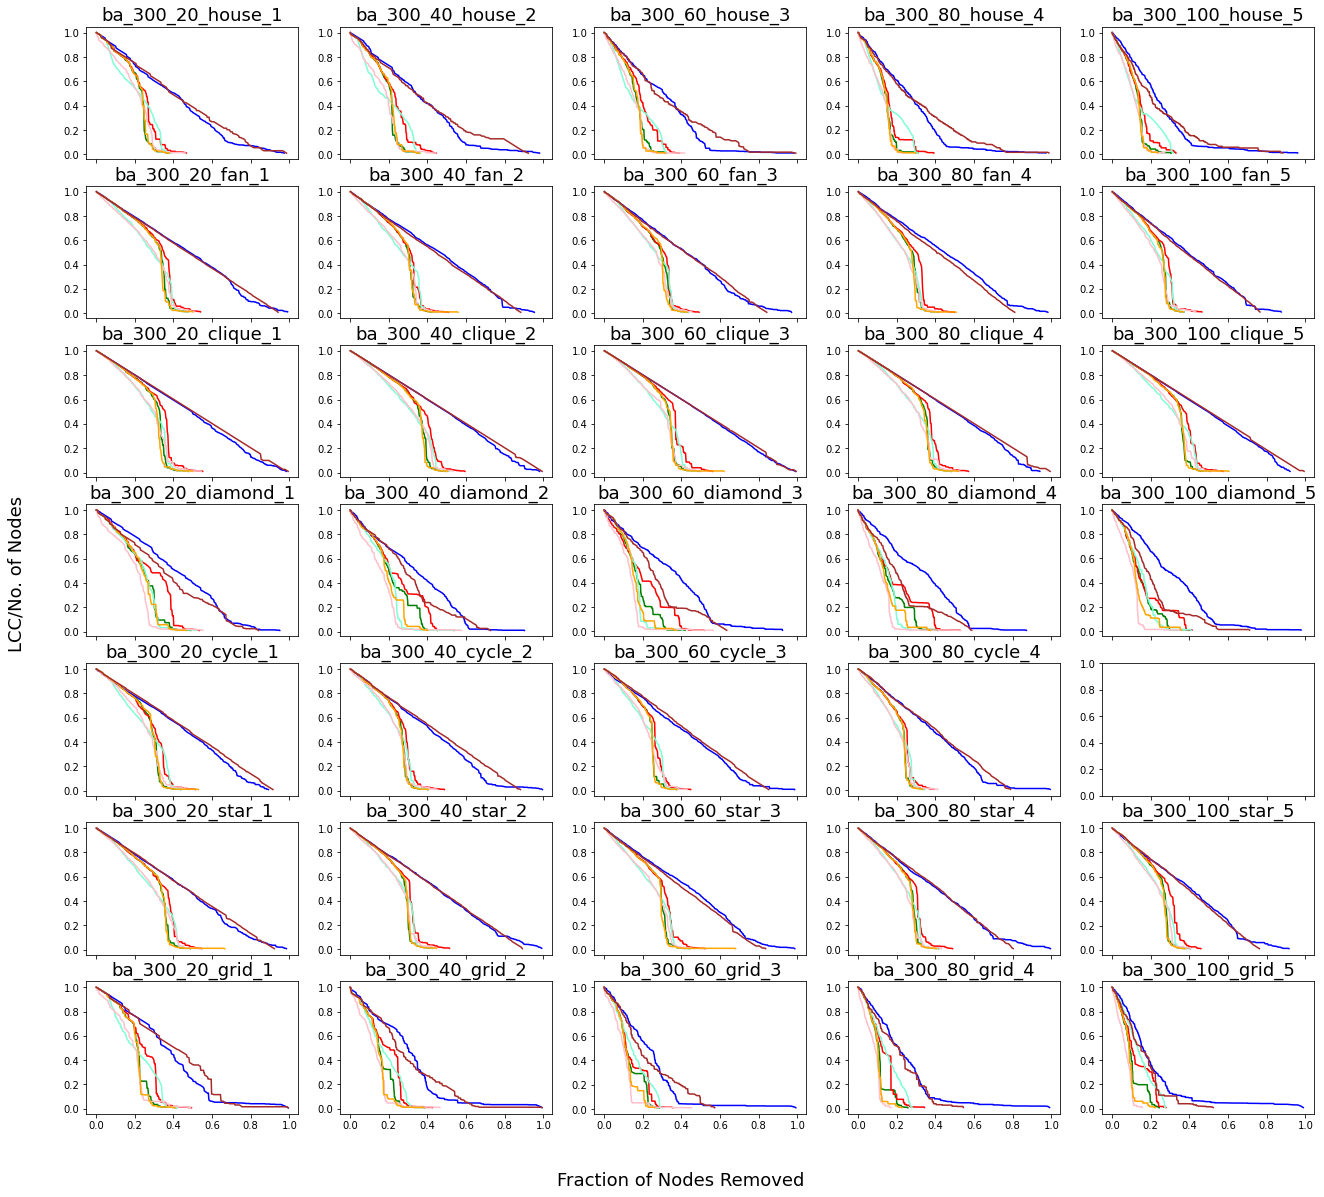

In [5]:
BA = 295500
MIX = 212500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


## Tree

tree_8_20_house_1 ,[248, 60, 195, 57, 111, 556, 21, 357, 50, 2, 65, 272, 23, 55, 17, 19, 531, 69, 67, 22, 43, 565, 563, 167, 260, 145, 277, 63, 52, 603, 59, 61, 222, 37, 246, 146, 83, 89, 204, 51, 543, 53, 54, 58, 62, 64, 68, 70, 164, 196, 38, 80, 94, 537, 564, 3, 532, 540, 533, 66, 236, 148, 143, 173, 176, 368, 265, 239, 56, 240, 151, 1, 567, 186, 218, 45, 235, 208, 200, 244, 259, 149, 171, 573, 558, 569, 153, 554, 233, 321, 534, 188, 572, 215, 216, 557, 250, 39, 177, 193, 568, 474, 553, 205, 249, 182, 262, 254, 270, 266, 159, 184, 206, 256, 157, 275, 155, 210, 242, 42, 226, 202, 47, 13, 15, 198, 212, 228, 230, 35, 278, 252, 34, 268, 40, 154, 209]
[60, 195, 578, 63, 183, 111, 368, 591, 13, 556, 554, 576, 57, 153, 472, 565, 19, 69, 531, 50, 563, 72, 68, 589, 564, 2, 248, 260, 254, 23, 541, 175, 272, 65, 21, 477, 574, 17, 55, 357, 570, 52, 537, 89, 534, 43, 3, 540, 538, 533, 59, 61, 532, 205, 90, 38, 181, 285, 5, 525, 437, 42, 67, 117, 559, 200, 561, 56, 244, 12, 140, 53, 250, 95, 79, 2

[204, 124, 228, 94, 75, 148, 120, 100, 192, 121, 174, 191, 84, 227, 226, 55, 146, 132, 6, 119, 29, 30, 197, 110, 158, 155, 180, 81, 193, 76, 116, 18, 24, 19, 706, 216, 661, 108, 48, 184, 144, 651, 16, 12, 196, 28, 173, 22, 103, 21, 15, 254, 626, 20, 92, 17, 125, 64, 172, 195, 145, 87, 183, 106, 118, 67, 83, 627, 708, 179, 188, 149, 194, 131, 147, 203, 11, 2, 215, 225, 648, 646, 162, 551, 553, 161, 102, 199, 210, 140, 70, 139, 536, 537, 246, 160, 1, 68, 166, 165, 123, 150, 235, 236, 109, 209, 200, 374, 656, 88, 90, 66, 583, 581, 63, 115, 105, 198, 143, 114, 589, 533, 531, 27, 526, 557, 686, 511, 631, 25, 26, 340, 687, 365, 185, 234, 505, 559, 562, 564, 633, 207, 221, 77, 571, 573, 462, 547, 549, 576, 578, 611, 613, 710, 497, 130, 658, 541, 543, 591, 593, 616, 618, 681, 683, 175, 206, 208, 569, 567, 652, 524, 522, 519, 517, 512, 241, 671, 673, 214, 79, 93, 696, 701, 170, 167, 670, 662, 644, 642, 677, 679, 621, 152, 604, 602, 587, 315]
[116, 84, 706, 11, 16, 22, 2, 76, 148, 228, 100, 192,

[184, 150, 96, 168, 80, 190, 136, 24, 191, 541, 192, 5, 163, 93, 120, 208, 149, 212, 128, 104, 186, 112, 110, 180, 79, 121, 88, 69, 203, 122, 29, 40, 25, 78, 183, 71, 44, 681, 801, 546, 13, 10, 124, 223, 107, 247, 179, 23, 75, 87, 115, 200, 445, 16, 141, 786, 26, 127, 245, 140, 65, 68, 147, 207, 146, 142, 158, 648, 646, 106, 126, 9, 15, 30, 8, 145, 173, 164, 167, 135, 119, 211, 204, 129, 77, 171, 195, 221, 228, 227, 235, 563, 561, 1, 788, 130, 170, 682, 148, 558, 556, 236, 234, 114, 109, 199, 201, 49, 197, 196, 181, 185, 731, 172, 678, 676, 668, 666, 653, 651, 76, 601, 182, 66, 251, 202, 58, 237, 238, 108, 102, 198, 189, 165, 166, 36, 553, 551, 252, 42, 169, 707, 706, 174, 536, 531, 511, 577, 761, 741, 18, 27, 22, 763, 139, 572, 574, 143, 579, 175, 356, 465, 494, 131, 582, 584, 151, 159, 187, 214, 215, 242, 603, 661, 663, 611, 613, 606, 608, 621, 623, 111, 123, 67, 752]
[736, 112, 50, 120, 168, 5, 801, 16, 84, 25, 546, 10, 191, 8, 29, 79, 99, 53, 136, 71, 671, 61, 40, 78, 541, 13, 64, 

[681, 621, 896, 881, 571, 821, 776, 84, 123, 606, 100, 796, 797, 646, 696, 871, 791, 726, 546, 80, 856, 686, 641, 651, 119, 106, 125, 761, 110, 91, 731, 826, 851, 626, 701, 841, 876, 816, 846, 756, 766, 866, 901, 721, 711, 206, 566, 562, 741, 716, 120, 781, 811, 801, 68, 596, 771, 108, 616, 661, 126, 676, 521, 536, 586, 551, 787, 673, 807, 806, 832, 90, 192, 751, 836, 886, 631, 122, 234, 634, 656, 527, 910, 96, 746, 78, 526, 185, 666, 592, 908, 511, 19, 637, 150, 691, 219, 891, 37, 861, 736, 89, 542, 597, 50, 517, 1, 8, 36, 531, 556, 6, 11, 82, 558, 165, 273, 582, 581, 602, 601, 47, 10, 26, 613, 20, 25, 171, 16, 579, 707, 706, 85, 86, 124, 577, 104, 70, 69, 103, 97, 228, 60, 71, 46, 56, 27, 28, 57, 114, 93, 111, 65, 117, 66, 118, 87, 31, 64, 15, 127, 177, 145, 77, 98, 99, 225, 72, 164, 163, 81, 79, 83, 105, 737, 671, 611, 107, 203]
[180, 123, 30, 234, 126, 125, 108, 119, 106, 151, 37, 154, 114, 155, 110, 145, 186, 177, 166, 127, 896, 182, 102, 150, 240, 69, 152, 164, 83, 144, 204, 100,

tree_8_100_house_5 ,[11, 307, 42, 36, 108, 91, 43, 172, 319, 39, 218, 828, 248, 120, 271, 135, 38, 197, 603, 611, 58, 55, 739, 288, 31, 93, 293, 167, 926, 96, 543, 604, 23, 405, 690, 256, 66, 348, 799, 748, 410, 69, 118, 284, 627, 53, 47, 291, 191, 105, 347, 435, 583, 726, 360, 805, 27, 72, 7, 581, 715, 623, 169, 75, 282, 127, 582, 363, 507, 132, 227, 249, 804, 593, 224, 417, 864, 1006, 660, 996, 902, 102, 107, 180, 6, 266, 277, 574, 160, 615, 40, 575, 260, 231, 202, 620, 150, 285, 65, 551, 956, 629, 598, 175, 219, 294, 255, 621, 619, 243, 608, 26, 637, 600, 2, 601, 605, 610, 628, 595, 3, 614, 580, 586, 612, 631, 89, 587, 585, 613, 584, 634, 644, 588, 222, 236, 41, 158, 247, 74, 710, 733, 67, 64, 599, 182, 626, 630, 741, 832, 636, 685, 698, 596, 633, 641, 616, 719, 229, 9, 199, 643, 62, 665, 57, 217, 639, 591, 68, 189, 213, 456, 225, 244, 279, 111, 254, 54, 166, 242, 268, 274, 298, 230, 455, 208, 721, 764, 757, 812, 624, 1, 50, 61, 170, 173, 147, 342, 374, 183, 394, 430, 506, 161, 206,

[641, 645, 130, 642, 643, 644, 10, 258, 128, 581, 585, 582, 583, 584, 646, 649, 135, 648, 67, 647, 650, 586, 590, 589, 587, 588, 967, 970, 968, 969, 966, 455, 846, 849, 335, 848, 847, 850, 167, 556, 559, 560, 558, 557, 30, 338, 35, 72, 145, 931, 934, 933, 935, 932, 301, 666, 669, 668, 348, 173, 670, 667, 776, 265, 779, 780, 379, 778, 132, 777, 771, 774, 260, 775, 772, 773, 977, 238, 978, 980, 979, 976, 36, 17, 526, 530, 527, 528, 529, 781, 327, 163, 784, 270, 783, 782, 785, 686, 175, 689, 690, 687, 87, 688, 921, 410, 925, 924, 922, 923, 856, 860, 857, 345, 172, 858, 859, 566, 570, 569, 568, 567, 517, 518, 371, 519, 520, 516, 626, 630, 629, 946, 949, 948, 947, 950, 435, 217, 108, 796, 285, 800, 142, 797, 799, 798, 881, 885, 370, 836, 839, 325, 838, 837, 162, 840, 876, 365, 182, 880, 877, 878, 879, 317, 158, 916, 405, 202, 98, 198, 398, 197, 736, 739, 225, 740, 737, 738, 456, 112, 227, 113, 561, 564, 563, 565, 562, 766, 255, 127, 769, 768, 770, 767, 706, 709, 195, 710, 707, 708, 105, 211

tree_8_40_fan_2 ,[58, 180, 6, 16, 38, 4, 36, 125, 32, 44, 20, 28, 105, 49, 67, 26, 73, 253, 128, 196, 131, 46, 108, 83, 68, 35, 124, 190, 43, 117, 72, 9, 48, 45, 110, 42, 63, 66, 182, 47, 34, 53, 37, 457, 200, 137, 40, 24, 236, 276, 152, 266, 70, 14, 25, 2, 259, 119, 114, 159, 93, 149, 205, 52, 56, 209, 69, 187, 155, 122, 174, 213, 226, 232, 274, 172, 247, 268, 280, 462, 237, 126, 192, 220, 261, 5, 55, 121, 147, 188, 170, 151, 413, 197, 218, 167, 176, 64, 201, 183, 224, 15, 207, 153, 277, 157, 178, 185, 194, 251, 263, 281]
[484, 6, 383, 485, 538, 384, 548, 544, 180, 11, 15, 31, 20, 235, 19, 58, 70, 28, 16, 105, 12, 87, 53, 48, 17, 93, 62, 73, 200, 63, 371, 80, 322, 187, 13, 213, 175, 137, 183, 152, 249, 131, 50, 83, 150, 413, 51, 59, 23, 234, 182, 269, 72, 415, 125, 110, 18, 117, 68, 218, 21, 181, 121, 161, 201, 194, 185, 69, 82, 98, 253, 304, 162, 84, 26, 66, 45, 55, 126, 78, 227, 247, 46, 199, 195, 22, 1, 145, 176, 208, 147, 457, 88, 178, 263, 452, 516, 79, 202, 267, 272, 275, 279, 1

[117, 519, 526, 125, 120, 62, 4, 257, 551, 320, 56, 113, 415, 207, 114, 103, 229, 459, 112, 226, 345, 287, 143, 225, 172, 451, 493, 85, 246, 72, 520, 145, 146, 292, 450, 436, 45, 91, 183, 368, 310, 154, 76, 37, 2, 68, 138, 278, 511, 0, 137, 1, 275, 561, 400, 199, 99, 21, 43, 372, 185, 92, 186, 438, 88, 52, 430, 214, 106, 213, 458, 228, 95, 47, 245, 122, 60, 31, 64, 63, 128, 527, 130, 261, 312, 155, 77, 116, 57, 233, 468, 284, 141, 220, 217, 442, 472, 235, 382, 190, 94, 46, 22, 10, 457, 267, 133, 61, 123, 124, 247, 30, 495, 50, 159, 102, 205, 79, 32, 66, 134, 270, 65, 132, 266, 15, 240, 100, 49, 24, 286, 202, 548, 296, 147, 142, 70, 17, 35, 71, 144, 13, 28, 58, 6, 14, 27, 55, 118, 29, 237, 476, 59, 522, 119, 239, 480, 218, 393, 196, 108, 53, 33, 447, 67, 223, 111, 224, 383, 191, 161, 80, 39, 19, 9, 20, 42, 86, 281, 140, 69, 34, 16, 7, 3, 8, 18, 38, 78, 157, 316, 392, 195, 97, 48, 23, 11, 5, 90, 181, 182, 44, 366, 363, 249, 499, 51, 25, 289, 12, 545, 272, 26, 135, 54, 362, 109, 180, 219,

[180, 205, 120, 70, 150, 210, 215, 220, 130, 235, 185, 175, 145, 135, 125, 244, 80, 195, 160, 140, 35, 105, 25, 224, 50, 203, 365, 188, 132, 110, 32, 85, 187, 250, 90, 129, 209, 207, 254, 30, 236, 75, 16, 108, 170, 226, 26, 193, 165, 201, 21, 20, 400, 159, 94, 73, 115, 60, 604, 200, 27, 19, 138, 455, 95, 28, 374, 22, 118, 15, 153, 5, 18, 78, 98, 113, 100, 154, 169, 127, 179, 122, 131, 143, 81, 248, 133, 249, 173, 206, 213, 119, 216, 23, 4, 91, 134, 137, 166, 214, 83, 174, 77, 315, 144, 116, 114, 425, 204, 0, 247, 253, 149, 3, 128, 29, 103, 111, 335, 88, 92, 295, 380, 563, 561, 330, 305, 370, 460, 480, 586, 17, 161, 385, 470, 557, 31, 177, 61, 232, 211, 202, 96, 87, 358, 340, 148, 67, 72, 142, 440, 242, 475, 109, 435, 24, 99, 395, 97, 172, 162, 69, 252, 112]
[35, 60, 10, 32, 16, 236, 26, 180, 193, 20, 25, 130, 30, 37, 39, 50, 55, 58, 94, 3, 250, 165, 23, 67, 100, 108, 207, 21, 400, 45, 110, 115, 5, 140, 41, 85, 120, 188, 56, 90, 73, 40, 105, 129, 209, 88, 95, 38, 125, 203, 244, 128, 70,

tree_8_40_clique_2 ,[3, 21, 131, 75, 224, 51, 62, 6, 35, 47, 135, 107, 163, 5, 7, 185, 116, 234, 155, 207, 110, 120, 137, 42, 64, 37, 58, 66, 45, 11, 117, 202, 53, 44, 49, 156, 36, 60, 46, 63, 65, 57, 48, 55, 159, 252, 38, 50, 222, 134, 52, 245, 165, 81, 141, 261, 183, 122, 250, 216, 240, 168, 166, 124, 152, 22, 146, 4, 205, 198, 34, 39, 138, 142, 196, 190, 144, 255, 170, 203, 61, 172, 188, 174, 218, 194, 54, 56, 235, 232, 210, 247, 178, 253, 176, 257, 259, 444, 180, 186, 192, 199, 220]
[3, 403, 404, 131, 86, 22, 75, 224, 21, 198, 353, 16, 5, 6, 171, 135, 92, 51, 138, 185, 107, 62, 118, 8, 137, 155, 207, 141, 263, 455, 179, 65, 117, 40, 56, 45, 454, 49, 157, 64, 52, 218, 183, 17, 203, 29, 31, 47, 146, 142, 105, 261, 121, 253, 163, 154, 176, 192, 165, 144, 247, 438, 196, 156, 210, 36, 30, 257, 152, 354, 186, 249, 194, 169, 120, 80, 259, 84, 212, 122, 139, 37, 201, 116, 251, 50, 10, 234, 41, 428, 104, 35, 245, 248, 115, 112, 215, 313, 235, 252, 53, 63, 260, 177, 24, 34, 211, 57, 314, 432

[511, 272, 216, 376, 187, 344, 104, 168, 288, 184, 336, 296, 408, 312, 93, 136, 456, 256, 360, 432, 472, 167, 200, 83, 135, 384, 171, 192, 280, 240, 328, 368, 227, 72, 215, 191, 440, 143, 400, 352, 113, 95, 199, 85, 264, 131, 203, 65, 99, 127, 32, 101, 320, 416, 207, 219, 24, 181, 49, 90, 23, 47, 11, 96, 193, 388, 89, 180, 179, 361, 504, 44, 251, 53, 108, 48, 218, 438, 382, 190, 107, 235, 117, 20, 41, 42, 448, 223, 54, 110, 222, 109, 406, 446, 26, 220, 284, 39, 341, 170, 84, 80, 162, 169, 340, 94, 46, 38, 78, 77, 155, 50, 158, 298, 148, 102, 205, 311, 412, 423, 247, 495, 176, 348, 173, 86, 174, 350, 499, 29, 464, 231, 33, 67, 68, 137, 510, 319, 254, 126, 159, 79, 160, 4, 9, 19, 40, 81, 163, 30, 14, 62, 125, 252, 304, 52, 106, 214, 429, 141, 70, 43, 87, 88, 175, 177, 21, 10, 355, 22, 112, 393, 196, 97, 392, 195, 122, 245, 403, 246, 466, 232, 115, 201, 100, 202, 405, 418, 208, 124, 61, 249, 489, 123, 248, 244, 497, 450, 2, 6, 0, 5, 1, 12, 25, 51, 103, 367, 183, 91, 45, 299, 300, 64, 139,

[184, 511, 109, 126, 240, 152, 145, 188, 87, 84, 9, 96, 80, 25, 157, 28, 17, 71, 103, 89, 198, 221, 217, 64, 23, 26, 107, 10, 69, 46, 91, 65, 81, 74, 99, 105, 251, 30, 113, 123, 85, 118, 225, 121, 29, 241, 102, 154, 196, 138, 7, 1, 176, 197, 135, 137, 146, 151, 189, 155, 195, 181, 136, 245, 100, 246, 234, 233, 114, 117, 104, 27, 63, 190, 92, 88, 182, 83, 166, 79, 86, 158, 37, 38, 129, 70, 33, 73, 480, 115, 249, 226, 224, 2, 250, 106, 242, 192, 165, 24, 66, 223, 218, 222, 101, 19, 20, 21, 15, 282, 215, 119, 267, 412, 415, 139, 132, 281, 180, 125, 150, 164, 170, 220, 11, 219, 169, 8, 248, 268, 270, 254, 237, 228, 216, 93, 12, 206, 390, 48, 288, 55, 423, 229, 161]
[511, 64, 5, 46, 188, 25, 28, 9, 23, 53, 7, 43, 27, 80, 84, 91, 30, 17, 67, 198, 29, 24, 10, 18, 221, 96, 89, 126, 244, 241, 152, 69, 240, 32, 199, 109, 247, 40, 138, 176, 42, 78, 103, 116, 145, 196, 102, 74, 105, 112, 113, 118, 215, 251, 160, 186, 76, 217, 231, 71, 100, 122, 124, 204, 70, 132, 164, 190, 195, 242, 1, 63, 83, 90,

[261, 150, 532, 278, 256, 171, 102, 543, 535, 149, 176, 42, 140, 249, 91, 4, 232, 538, 542, 41, 251, 182, 244, 2, 533, 172, 269, 541, 71, 86, 536, 109, 27, 526, 108, 161, 174, 254, 260, 63, 534, 378, 155, 78, 131, 58, 139, 39, 82, 84, 121, 15, 547, 240, 537, 166, 136, 546, 191, 545, 215, 153, 209, 238, 241, 202, 25, 194, 115, 275, 246, 233, 187, 231, 236, 245, 566, 255, 257, 258, 265, 23, 49, 50, 64, 3, 29, 122, 206, 185, 222, 28, 216, 262, 175, 228, 36, 53, 16, 24, 68, 188, 144, 170, 271, 160, 544, 446, 75, 219, 199, 200, 195, 167, 197, 458, 585, 104, 539, 204, 237, 250, 184, 51, 60, 11, 229, 169, 117, 168, 6, 17, 112, 116, 618, 76, 105, 110, 540, 553, 594, 599, 610, 264, 183, 214, 573, 598, 551, 225, 118, 588, 54, 277, 562, 623, 549, 569, 611, 621, 625, 243, 224, 266, 43, 67, 135, 248, 154, 596, 589, 572, 558, 620, 608, 145, 239, 179, 141, 65, 548, 235, 62, 77, 454, 475, 52, 208, 267, 272, 563, 137, 5, 274, 44, 103, 165, 227, 56, 301, 156, 369, 212, 159, 374, 1, 390, 327, 523, 7, 21,

[31, 208, 191, 554, 276, 149, 161, 158, 313, 45, 122, 237, 107, 193, 558, 532, 226, 248, 205, 128, 568, 573, 88, 132, 204, 560, 268, 256, 541, 167, 656, 231, 517, 420, 578, 614, 143, 655, 50, 30, 259, 563, 214, 79, 206, 552, 550, 207, 160, 200, 569, 565, 571, 575, 312, 557, 556, 80, 546, 555, 551, 10, 178, 548, 162, 404, 203, 28, 119, 23, 78, 133, 201, 103, 581, 145, 171, 270, 113, 222, 77, 154, 591, 57, 112, 241, 238, 590, 219, 16, 18, 196, 33, 166, 62, 175, 185, 236, 212, 249, 46, 217, 566, 230, 421, 176, 17, 25, 12, 9, 83, 229, 199, 198, 186, 187, 218, 197, 271, 2, 1, 562, 547, 245, 681, 626, 549, 195, 172, 570, 38, 559, 148, 553, 66, 118, 609, 151, 210, 616, 622, 610, 182, 252, 281, 319, 621, 713, 750, 209, 348, 388, 223, 373, 605, 631, 692, 718, 741, 34, 491, 567, 617, 666, 716, 747, 242, 673, 194, 330, 184, 188, 266, 721, 586, 644, 670, 604, 584, 599, 615, 620, 639, 643, 689, 129, 43, 466, 3, 683, 140, 11, 27, 42, 48, 51, 64, 70, 71, 108, 130, 138, 163, 183, 263, 725, 173, 91, 12

[128, 236, 214, 119, 687, 159, 176, 218, 123, 72, 196, 164, 200, 24, 201, 199, 133, 242, 215, 226, 225, 177, 210, 209, 152, 91, 76, 243, 308, 241, 29, 211, 246, 70, 136, 197, 80, 134, 129, 69, 74, 179, 724, 84, 110, 144, 96, 203, 23, 16, 659, 95, 165, 163, 166, 40, 135, 111, 113, 235, 28, 116, 195, 115, 79, 9, 127, 83, 171, 172, 178, 32, 131, 30, 126, 799, 114, 155, 27, 151, 18, 78, 204, 579, 68, 71, 17, 296, 162, 666, 202, 198, 130, 6, 217, 175, 26, 109, 86, 180, 125, 188, 185, 190, 186, 44, 124, 118, 232, 182, 181, 73, 102, 43, 10, 94, 187, 244, 1, 577, 553, 673, 103, 511, 795, 762, 834, 740, 793, 714, 25, 106, 859, 547, 67, 516, 864, 863, 861, 844, 591, 546, 518, 841, 843, 842, 338, 139, 223, 183, 520, 521, 522, 681, 541, 543, 545, 143, 619, 621, 623, 624, 675, 678, 677, 515, 513, 167, 207, 227, 460, 439, 446, 502, 679, 22, 194, 555, 558, 557, 386, 581, 285, 597, 20, 477, 233, 318, 276, 680, 682, 122, 15, 140, 442, 339, 668, 665, 663, 661, 655, 191, 649, 650, 651, 652, 637, 639, 641

[348, 349, 683, 96, 89, 351, 611, 49, 319, 196, 80, 690, 488, 770, 624, 709, 185, 759, 927, 655, 747, 439, 666, 633, 744, 212, 873, 706, 851, 809, 785, 868, 728, 198, 323, 365, 517, 86, 753, 837, 656, 710, 524, 609, 739, 668, 825, 640, 748, 166, 733, 856, 362, 693, 612, 952, 814, 956, 27, 726, 53, 24, 610, 223, 779, 831, 769, 915, 985, 881, 679, 324, 749, 645, 603, 601, 630, 605, 613, 231, 705, 700, 688, 474, 631, 653, 504, 642, 648, 597, 602, 650, 619, 448, 606, 732, 56, 689, 169, 716, 217, 644, 38, 402, 720, 636, 13, 153, 366, 562, 428, 257, 405, 718, 289, 639, 719, 65, 953, 629, 267, 607, 736, 627, 35, 395, 771, 828, 72, 695, 73, 882, 622, 754, 64, 498, 649, 654, 823, 815, 843, 116, 659, 295, 664, 43, 707, 670, 782, 66, 787, 316, 911, 897, 555, 580, 943, 643, 652, 7, 206, 761, 766, 810, 803, 41, 499, 859, 424, 869, 949, 903, 963, 676, 621, 93, 923, 939, 114, 142, 156, 552, 672, 712, 727, 776, 799, 808, 822, 850, 867, 878, 908, 150, 51, 919, 932, 936, 965, 981, 990, 132, 276, 52, 8, 

[556, 766, 684, 424, 211, 631, 516, 943, 432, 215, 692, 805, 294, 146, 655, 144, 895, 384, 191, 592, 715, 687, 661, 520, 353, 848, 317, 333, 825, 907, 396, 197, 917, 604, 877, 366, 888, 382, 190, 94, 727, 216, 107, 775, 577, 841, 304, 330, 952, 889, 378, 532, 311, 823, 312, 151, 155, 637, 579, 757, 246, 697, 43, 264, 769, 258, 931, 961, 450, 863, 257, 128, 63, 524, 608, 373, 920, 630, 339, 169, 535, 793, 282, 140, 69, 837, 175, 87, 176, 354, 799, 288, 143, 71, 583, 781, 270, 134, 572, 643, 901, 549, 285, 142, 45, 91, 132, 358, 183, 368, 979, 468, 925, 817, 306, 152, 75, 871, 739, 829, 318, 158, 667, 156, 77, 717, 653, 455, 738, 542, 360, 179, 562, 710, 831, 495, 247, 619, 968, 350, 957, 708, 283, 141, 70, 34, 751, 819, 887, 835, 324, 161, 694, 879, 613, 629, 939, 122, 565, 615, 298, 985, 474, 815, 673, 162, 721, 518, 787, 745, 234, 973, 462, 230, 547, 937, 426, 212, 105, 955, 444, 777, 723, 685, 174, 595, 47, 356, 95, 192, 853, 342, 170, 869, 90, 783, 645, 981, 12, 859, 348, 707, 585, 

[190, 165, 68, 214, 529, 65, 230, 160, 224, 242, 246, 80, 184, 187, 186, 171, 229, 211, 222, 244, 243, 67, 124, 149, 182, 130, 140, 166, 232, 209, 723, 153, 829, 223, 134, 245, 73, 946, 99, 180, 145, 35, 217, 991, 199, 27, 231, 220, 112, 141, 577, 164, 174, 934, 16, 45, 751, 985, 20, 661, 62, 159, 19, 579, 254, 559, 172, 613, 100, 95, 53, 189, 219, 197, 5, 23, 24, 194, 97, 25, 241, 78, 154, 77, 572, 75, 8, 212, 10, 1, 643, 84, 14, 142, 206, 177, 234, 621, 258, 247, 235, 44, 1009, 207, 248, 877, 743, 757, 619, 181, 15, 71, 178, 57, 119, 46, 129, 188, 917, 918, 167, 210, 1081, 216, 2, 583, 708, 558, 557, 554, 556, 771, 1006, 571, 573, 574, 862, 847, 944, 741, 739, 744, 879, 629, 997, 563, 891, 647, 648, 645, 721, 724, 722, 1087, 976, 983, 1059, 889, 236, 699, 745, 1004, 1057, 578, 96, 511, 537, 691, 817, 102, 69, 755, 996, 894, 562, 973, 943, 864, 663, 72, 1060, 979, 290, 630, 628, 626, 147, 893, 820, 410, 1011, 1010, 1012, 316, 108, 945, 59, 61, 580, 83, 202, 878, 880, 916, 914, 1085, 1

tree_8_20_cycle_1 ,[54, 2, 5, 53, 520, 131, 21, 235, 57, 36, 62, 104, 39, 46, 63, 11, 35, 60, 50, 79, 49, 65, 55, 82, 38, 187, 45, 42, 34, 208, 61, 58, 37, 51, 48, 64, 59, 43, 44, 47, 212, 259, 156, 183, 150, 535, 530, 630, 539, 555, 533, 56, 529, 532, 538, 537, 264, 234, 3, 524, 246, 542, 534, 196, 14, 17, 138, 9, 40, 41, 133, 135, 139, 256, 141, 143, 145, 147, 151, 153, 193, 160, 185, 162, 167, 169, 171, 173, 175, 177, 179, 181, 189, 191, 197, 199, 201, 203, 205, 214, 216, 244, 218, 220, 222, 224, 226, 228, 230, 232, 236, 238, 240, 242, 248, 250, 252, 254, 531]
[6, 4, 28, 5, 131, 52, 235, 557, 7, 14, 82, 38, 212, 47, 315, 11, 9, 62, 57, 65, 314, 98, 552, 156, 32, 236, 46, 316, 59, 157, 553, 89, 36, 167, 139, 49, 199, 171, 133, 216, 203, 21, 150, 175, 240, 85, 191, 34, 15, 50, 214, 259, 37, 115, 543, 184, 554, 207, 43, 535, 373, 176, 237, 111, 170, 241, 217, 45, 563, 541, 35, 155, 96, 60, 63, 64, 183, 208, 234, 555, 205, 104, 242, 39, 318, 540, 264, 533, 213, 23, 108, 143, 317, 588, 7

[96, 84, 12, 24, 21, 38, 72, 29, 36, 48, 15, 27, 124, 19, 16, 22, 28, 108, 75, 109, 180, 204, 228, 30, 20, 120, 691, 160, 144, 52, 132, 192, 0, 216, 252, 541, 182, 254, 92, 116, 156, 168, 104, 240, 68, 80, 86, 733, 157, 195, 709, 8, 214, 63, 66, 69, 81, 87, 93, 99, 111, 117, 121, 661, 723, 203, 739, 643, 673, 697, 110, 655, 679, 703, 727, 114, 667, 745, 150, 584, 598, 649, 685, 198, 715, 76, 102, 103, 64, 67, 70, 82, 85, 88, 91, 94, 100, 112, 115, 118, 122, 123, 646, 721, 748, 11, 44, 62, 147, 211, 215, 511, 517, 523, 529, 535, 547, 553, 559, 565, 571, 577, 589, 601, 607, 613, 619, 625, 631, 637, 674, 698, 734]
[166, 25, 169, 153, 229, 199, 259, 262, 263, 206, 142, 80, 265, 178, 83, 140, 544, 154, 130, 391, 223, 106, 64, 545, 546, 564, 568, 361, 96, 116, 188, 225, 244, 102, 557, 386, 11, 569, 269, 266, 242, 12, 95, 90, 29, 30, 38, 162, 226, 170, 254, 549, 563, 565, 566, 152, 228, 264, 135, 136, 149, 163, 173, 231, 36, 42, 71, 127, 151, 552, 553, 230, 3, 562, 137, 219, 43, 185, 20, 55, 

[17, 16, 24, 26, 208, 48, 59, 43, 40, 1, 112, 64, 71, 56, 80, 30, 32, 67, 96, 105, 18, 22, 28, 20, 104, 219, 146, 128, 184, 200, 160, 192, 242, 250, 251, 152, 168, 216, 232, 34, 224, 2, 153, 186, 202, 248, 267, 89, 93, 85, 60, 176, 25, 73, 77, 101, 117, 240, 81, 97, 716, 818, 169, 729, 577, 721, 759, 703, 751, 823, 843, 565, 215, 231, 709, 739, 763, 787, 799, 811, 847, 853, 517, 110, 126, 601, 775, 793, 529, 90, 141, 610, 613, 619, 632, 656, 668, 733, 745, 769, 781, 805, 829, 865, 249, 511, 108, 116, 835, 859, 68, 74, 78, 86, 94, 102, 106, 118, 727, 757, 796, 19, 27, 15, 23, 37, 41, 45, 49]
[48, 174, 214, 176, 149, 254, 183, 205, 142, 244, 231, 226, 171, 277, 189, 188, 163, 35, 573, 597, 569, 108, 250, 192, 245, 29, 133, 578, 579, 586, 130, 127, 321, 201, 274, 464, 584, 160, 572, 574, 589, 601, 339, 533, 551, 24, 128, 65, 1, 141, 177, 196, 585, 598, 200, 213, 223, 241, 266, 257, 566, 581, 590, 602, 604, 151, 148, 570, 594, 94, 207, 18, 37, 66, 80, 178, 92, 181, 219, 286, 393, 124, 154,

[18, 12, 30, 7, 24, 217, 42, 51, 110, 6, 36, 48, 90, 114, 92, 102, 60, 66, 19, 78, 96, 120, 72, 84, 21, 28, 75, 81, 101, 162, 216, 22, 126, 225, 33, 127, 174, 180, 156, 210, 228, 511, 755, 144, 175, 234, 867, 53, 132, 168, 192, 70, 111, 105, 138, 150, 198, 240, 252, 944, 31, 93, 99, 117, 147, 246, 1, 565, 770, 914, 782, 793, 891, 969, 123, 614, 778, 895, 988, 606, 218, 835, 856, 871, 549, 233, 799, 823, 847, 859, 931, 955, 27, 79, 88, 787, 560, 811, 907, 669, 131, 646, 694, 697, 715, 733, 741, 805, 817, 829, 841, 877, 883, 901, 919, 925, 937, 961, 973, 865, 967, 69, 106, 109, 115, 619, 949, 979, 76, 82, 91, 94, 100, 118, 124, 889, 795, 853, 897, 957, 985, 17, 23]
[160, 230, 251, 261, 94, 185, 285, 274, 244, 113, 172, 167, 126, 194, 579, 121, 215, 151, 586, 613, 97, 393, 58, 103, 200, 67, 149, 590, 607, 611, 614, 624, 157, 64, 43, 133, 193, 268, 258, 32, 576, 589, 591, 601, 603, 606, 155, 300, 201, 6, 47, 76, 21, 90, 132, 7, 196, 489, 146, 592, 595, 588, 51, 254, 283, 270, 87, 74, 70, 2

[733, 778, 96, 66, 125, 65, 95, 1048, 215, 85, 63, 211, 925, 80, 118, 90, 70, 110, 120, 75, 140, 71, 100, 186, 225, 175, 205, 92, 30, 20, 190, 40, 10, 43, 50, 60, 231, 195, 15, 79, 89, 525, 649, 99, 5, 57, 25, 119, 84, 64, 109, 673, 674, 715, 538, 48, 104, 746, 787, 697, 793, 691, 685, 811, 763, 117, 6, 55, 207, 914, 998, 671, 1105, 913, 1106, 1079, 920, 511, 854, 853, 543, 565, 637, 553, 967, 1003, 53, 76, 106, 754, 16, 46, 931, 937, 1021, 1023, 1027, 939, 1063, 187, 1051, 137, 147, 879, 955, 847, 871, 1069, 868, 841, 1039, 829, 889, 1057, 904, 907, 1041, 1015, 1099, 831, 985, 979, 711, 709, 805, 817, 823, 1087, 859, 883, 1093, 895, 949, 973, 976, 835, 991, 943, 1081, 67, 799, 727, 703, 1033, 72, 124, 123, 8, 56, 17, 36, 74, 113, 114, 77, 78, 91, 38, 1, 1045, 901, 694, 775, 751, 253, 667, 86, 83, 961, 964, 550, 877, 1011, 1009, 1075]
[140, 125, 160, 65, 66, 211, 210, 240, 155, 215, 165, 166, 180, 95, 96, 195, 198, 120, 85, 175, 170, 20, 23, 80, 40, 15, 25, 70, 71, 217, 90, 5, 10, 30, 

[200, 225, 250, 216, 74, 147, 17, 204, 50, 125, 133, 238, 100, 128, 91, 171, 192, 173, 205, 31, 25, 7, 224, 20, 10, 13, 1, 5, 29, 84, 23, 75, 18, 19, 88, 110, 26, 103, 89, 96, 215, 70, 106, 94, 67, 82, 191, 78, 71, 375, 242, 121, 79, 97, 237, 127, 181, 134, 156, 169, 69, 148, 155, 172, 182, 199, 203, 109, 174, 114, 249, 247, 245, 254, 98, 233, 57, 228, 61, 253, 108, 206, 80, 188, 87, 83, 81, 76, 145, 129, 68, 235, 234, 231, 227, 105, 92, 42, 65, 146, 130, 119, 232, 104, 223, 27, 21, 16, 286, 22, 120, 435, 425, 428, 518, 275, 362, 325, 359, 140, 143, 177, 170, 136, 62, 252, 243, 14, 112, 149, 122, 503, 117, 229, 475, 222, 2, 380, 187, 166, 271, 415, 193, 305]
[17, 60, 25, 50, 20, 10, 13, 205, 7, 125, 5, 86, 224, 133, 100, 38, 84, 96, 88, 19, 55, 110, 31, 30, 91, 23, 58, 89, 103, 217, 33, 75, 1, 147, 46, 26, 192, 59, 123, 98, 175, 238, 69, 82, 171, 71, 105, 56, 57, 80, 90, 150, 200, 375, 32, 127, 209, 107, 124, 186, 204, 245, 76, 237, 135, 70, 225, 168, 72, 79, 81, 97, 106, 109, 126, 137

tree_8_60_star_3 ,[80, 43, 235, 22, 107, 132, 126, 12, 227, 64, 42, 142, 36, 118, 45, 218, 271, 210, 196, 17, 11, 15, 119, 108, 62, 361, 41, 49, 90, 61, 51, 69, 68, 56, 116, 72, 240, 193, 228, 283, 266, 1, 253, 52, 50, 141, 172, 33, 150, 191, 134, 14, 70, 278, 13, 81, 37, 78, 200, 356, 91, 96, 551, 176, 73, 257, 55, 246, 181, 233, 38, 154, 9, 152, 209, 263, 158, 280, 286, 204, 54, 248, 167, 256, 203, 178, 213, 230, 267, 160, 46, 234, 175, 10, 239, 211, 169, 201, 173, 288, 545, 217, 247, 63, 188, 206, 97, 215, 264, 250, 254, 281, 275, 89, 368]
[325, 326, 327, 323, 18, 200, 25, 266, 107, 22, 288, 227, 499, 32, 80, 118, 556, 290, 54, 116, 42, 35, 27, 501, 63, 44, 67, 17, 193, 268, 91, 473, 73, 278, 30, 196, 408, 285, 175, 24, 70, 103, 62, 208, 228, 218, 3, 545, 240, 0, 158, 120, 15, 142, 490, 235, 262, 23, 341, 99, 281, 471, 334, 176, 424, 37, 216, 271, 150, 190, 83, 138, 264, 9, 121, 209, 100, 96, 49, 81, 178, 137, 277, 450, 10, 469, 29, 129, 182, 229, 108, 119, 45, 68, 114, 155, 417, 39

[173, 240, 228, 120, 278, 167, 201, 225, 7, 164, 282, 33, 199, 234, 241, 271, 265, 188, 177, 55, 231, 277, 219, 258, 268, 193, 42, 126, 217, 67, 262, 92, 34, 132, 192, 103, 174, 29, 97, 205, 207, 161, 249, 10, 157, 245, 85, 50, 215, 244, 0, 152, 200, 26, 37, 151, 153, 166, 221, 220, 229, 194, 98, 160, 28, 323, 238, 211, 239, 163, 149, 150, 213, 81, 155, 102, 25, 4, 276, 279, 275, 285, 297, 141, 185, 256, 133, 281, 388, 196, 283, 252, 226, 100, 147, 105, 204, 48, 182, 222, 146, 223, 22, 123, 27, 272, 260, 20, 214, 230, 191, 250, 9, 21, 180, 65, 82, 168, 23, 130, 242, 112, 63, 178, 563, 486, 93, 109, 57, 253, 162, 114, 548, 227, 243, 91, 53, 36, 90, 333, 246, 195, 263, 13, 52, 134, 175, 189, 203, 218, 269, 346, 347, 474, 492, 529, 295, 142, 41, 51, 45, 131, 144, 171, 118, 156, 495, 212, 232, 140, 264, 236, 233, 254, 5, 31, 46, 427, 139, 148, 202, 266, 571, 586, 546, 556, 165, 209, 170, 440, 84, 2, 14, 206, 190, 176, 349, 369, 516, 186, 255, 270, 32, 70, 247, 257, 559, 565, 584, 39, 107, 

tree_8_20_grid_1 ,[589, 315, 755, 595, 517, 648, 125, 588, 476, 590, 495, 577, 833, 801, 982, 618, 798, 1079, 736, 813, 689, 774, 992, 1142, 663, 943, 824, 908, 139, 1072, 889, 14, 1023, 710, 708, 570, 234, 684, 36, 18, 574, 431, 177, 997, 28, 563, 62, 653, 814, 672, 709, 277, 60, 19, 567, 615, 1214, 693, 164, 597, 599, 731, 884, 1050, 147, 767, 73, 558, 1189, 837, 828, 1154, 49, 857, 918, 1076, 913, 976, 749, 21, 895, 613, 946, 1015, 70, 794, 657, 726, 1228, 696, 1104, 55, 686, 854, 1087, 622, 1159, 568, 580, 926, 246, 1049, 571, 1066, 573, 701, 193, 579, 870, 1115, 865, 1183, 1220, 744, 787, 582, 954, 606, 987, 910, 740, 1020, 847, 817, 1134, 650, 677, 564, 635, 242, 930, 1069, 754, 1191, 12, 1097, 217, 1008, 668, 1222, 720, 715, 1144, 554, 984, 1161, 1045, 1204, 1085, 1194, 892, 763, 128, 853, 292, 203, 226, 742, 561, 57, 270, 628, 22, 921, 92, 602, 38, 1074, 638, 973, 950, 90, 138, 735, 790, 771, 326, 1208, 1179, 924, 1109, 1038, 821, 699, 1054, 1101, 873, 936, 609, 881, 0, 201, 53

[147, 653, 164, 246, 577, 954, 1044, 595, 202, 997, 919, 684, 709, 563, 19, 672, 801, 815, 495, 217, 287, 588, 62, 216, 602, 193, 928, 590, 286, 220, 98, 151, 1197, 726, 771, 943, 242, 1006, 564, 600, 837, 589, 575, 476, 908, 125, 390, 891, 932, 585, 315, 567, 578, 173, 195, 889, 921, 710, 817, 23, 258, 326, 573, 1204, 715, 885, 579, 749, 796, 215, 168, 200, 240, 233, 114, 25, 681, 981, 813, 768, 174, 864, 226, 270, 27, 649, 736, 116, 761, 1078, 1108, 593, 1087, 755, 86, 162, 1072, 594, 18, 142, 230, 689, 854, 1194, 70, 699, 719, 1158, 1163, 1208, 1223, 60, 687, 693, 1154, 1176, 1189, 1220, 596, 157, 1079, 99, 1047, 146, 247, 847, 1132, 234, 783, 763, 1017, 792, 660, 1171, 558, 568, 1124, 136, 762, 517, 740, 109, 618, 992, 580, 570, 696, 798, 1165, 185, 222, 239, 90, 265, 1049, 834, 925, 175, 1027, 601, 28, 280, 178, 36, 46, 221, 197, 14, 935, 995, 139, 931, 10, 821, 1026, 1179, 827, 677, 717, 1188, 930, 31, 1063, 63, 805, 92, 655, 163, 198, 264, 835, 867, 735, 1036, 1151, 829, 841, 10

tree_8_40_grid_2 ,[627, 720, 710, 625, 789, 310, 843, 837, 763, 1252, 793, 205, 624, 804, 639, 597, 781, 89, 648, 919, 1278, 167, 654, 747, 651, 422, 30, 971, 719, 1447, 1603, 1712, 1115, 1075, 1063, 1393, 866, 1648, 1066, 592, 1255, 1776, 901, 994, 297, 827, 718, 87, 1046, 846, 841, 1358, 957, 1105, 649, 1146, 1142, 198, 1285, 1744, 1217, 1507, 1466, 981, 1086, 1149, 249, 768, 875, 1931, 742, 604, 1321, 1121, 1415, 1000, 612, 1272, 48, 1108, 91, 824, 1338, 600, 954, 659, 252, 1183, 1387, 1541, 586, 1350, 810, 840, 864, 1034, 1295, 220, 699, 603, 1524, 58, 610, 1481, 1907, 1427, 688, 32, 730, 1501, 698, 920, 325, 1085, 1069, 636, 993, 680, 645, 105, 25, 633, 637, 46, 632, 19, 796, 616, 1342, 598, 1686, 1289, 61, 34, 1596, 1718, 1772, 1938, 1157, 1319, 749, 75, 50, 1886, 12, 976, 1032, 236, 299, 1883, 1130, 1445, 1251, 1706, 1023, 611, 678, 623, 62, 677, 939, 674, 724, 1134, 1018, 774, 1879, 464, 1178, 1382, 960, 1519, 1757, 1552, 1479, 294, 1904, 1056, 1680, 640, 1, 1880, 1777, 57, 817

[100, 192, 146, 246, 134, 127, 180, 132, 228, 238, 109, 195, 242, 1392, 121, 69, 123, 30, 125, 254, 1798, 67, 81, 692, 699, 694, 1307, 46, 92, 10, 1739, 24, 23, 5, 1186, 37, 1612, 1811, 1816, 1809, 88, 96, 824, 819, 812, 817, 856, 596, 17, 802, 841, 807, 814, 809, 816, 821, 1576, 1200, 1569, 1571, 1562, 1578, 1555, 1557, 1591, 227, 27, 235, 236, 6, 57, 29, 640, 1079, 714, 712, 928, 1338, 938, 931, 926, 933, 921, 916, 923, 210, 836, 909, 1779, 74, 619, 825, 1228, 105, 1887, 19, 79, 1281, 20, 86, 1634, 1641, 1636, 1629, 1631, 1038, 21, 576, 1774, 1772, 103, 1256, 25, 1783, 1784, 777, 567, 669, 574, 26, 1711, 107, 1067, 1072, 1065, 1060, 1058, 1053, 1074, 101, 1456, 1751, 903, 1743, 1347, 1755, 396, 144, 1375, 72, 1267, 1598, 1593, 1279, 1489, 1203, 1385, 1330, 1877, 1293, 1862, 957, 902, 895, 1446, 1430, 991, 1843, 84, 131, 524, 15, 682, 1451, 1458, 312, 77, 1463, 1129, 1461, 1468, 1473, 1479, 112, 730, 851, 1252, 1210, 879, 1096, 753, 1709, 772, 1515, 674, 858, 863, 868, 861, 1, 1390, 1

[1612, 777, 410, 1186, 307, 153, 76, 1279, 851, 1035, 567, 1307, 382, 190, 1308, 177, 94, 1533, 1535, 856, 1221, 141, 1456, 1853, 640, 669, 730, 1798, 510, 1576, 682, 1392, 488, 243, 536, 1538, 692, 407, 1634, 824, 1571, 1820, 957, 1028, 836, 1724, 1409, 1410, 575, 1504, 1796, 451, 225, 962, 1641, 1473, 1779, 1347, 753, 273, 1672, 1108, 895, 901, 699, 693, 841, 835, 1252, 1739, 1740, 370, 184, 91, 401, 200, 99, 986, 1637, 621, 539, 1599, 590, 1175, 950, 956, 1385, 1922, 72, 145, 1430, 714, 1682, 1887, 333, 166, 82, 1281, 319, 159, 79, 1743, 1877, 1878, 350, 1096, 1078, 524, 133, 843, 842, 397, 198, 712, 1383, 953, 755, 1784, 48, 97, 196, 394, 98, 197, 1711, 218, 1569, 1570, 1293, 1058, 531, 916, 1834, 326, 162, 1038, 1129, 1816, 1139, 772, 879, 69, 139, 279, 462, 230, 1338, 330, 1390, 1384, 1391, 78, 665, 1709, 837, 926, 599, 1463, 784, 778, 572, 1755, 1461, 1462, 1862, 1475, 1318, 1331, 1332, 1337, 1256, 427, 674, 1067, 435, 217, 108, 928, 1857, 1210, 809, 229, 114, 1774, 1773, 1591, 

tree_8_60_grid_3 ,[148, 1453, 758, 1156, 749, 943, 813, 780, 1792, 856, 970, 735, 1418, 621, 1560, 574, 692, 1110, 48, 604, 145, 905, 1340, 946, 1198, 2261, 617, 200, 1270, 2357, 1060, 33, 640, 178, 1316, 2487, 742, 1374, 1039, 1188, 1222, 902, 159, 1265, 826, 2427, 2217, 1987, 1851, 1517, 762, 1805, 1148, 952, 2469, 1298, 1182, 187, 2506, 1368, 2365, 717, 1876, 885, 1010, 1991, 254, 1255, 2101, 2276, 622, 1573, 691, 204, 1322, 215, 1630, 1530, 1904, 2154, 784, 1645, 1776, 922, 843, 1721, 1915, 2465, 1838, 630, 965, 2585, 741, 1317, 16, 225, 825, 1672, 767, 1005, 1200, 1472, 805, 961, 1625, 2484, 1536, 1780, 2419, 1611, 636, 20, 1697, 100, 140, 771, 1756, 1086, 677, 476, 222, 660, 409, 1157, 676, 688, 469, 627, 122, 1691, 1887, 912, 653, 2158, 2393, 2067, 1136, 2274, 1908, 1623, 1407, 293, 1294, 2016, 1771, 1225, 261, 827, 448, 2416, 1239, 1063, 959, 2316, 2656, 1184, 694, 1564, 1603, 555, 1028, 1207, 603, 1291, 1006, 811, 432, 302, 45, 2483, 2311, 972, 764, 1059, 2188, 1998, 689, 967,

[102, 104, 75, 118, 98, 112, 94, 96, 88, 161, 169, 249, 107, 64, 72, 81, 2605, 110, 207, 83, 76, 70, 1085, 131, 136, 95, 1483, 111, 80, 2014, 1696, 63, 2071, 93, 283, 1879, 32, 336, 1267, 914, 71, 1438, 69, 119, 117, 140, 188, 1298, 2524, 1843, 125, 1457, 1087, 895, 1691, 1834, 638, 1157, 120, 2148, 1591, 1995, 1159, 1464, 56, 752, 2527, 919, 20, 2577, 2021, 91, 101, 176, 79, 1490, 680, 1488, 175, 13, 85, 2241, 171, 1231, 1686, 1841, 1519, 86, 1771, 745, 952, 2167, 2084, 174, 2393, 643, 687, 1195, 1729, 211, 77, 16, 2018, 1375, 501, 2009, 1527, 1138, 2489, 212, 2400, 18, 244, 1288, 2239, 2386, 2091, 2249, 1673, 1202, 1778, 909, 82, 126, 123, 106, 759, 1450, 2203, 2600, 2169, 2542, 2224, 755, 1532, 2658, 2411, 1555, 917, 1133, 1475, 68, 2094, 115, 1886, 1094, 1951, 2347, 1774, 3, 1669, 1486, 1679, 950, 2461, 100, 1781, 2086, 387, 2087, 1140, 1628, 116, 1126, 24, 1537, 750, 1493, 916, 2416, 955, 40, 1735, 1958, 2456, 791, 2354, 924, 200, 199, 1480, 2404, 1544, 1064, 2663, 1472, 1788, 240

[593, 1238, 1367, 934, 2659, 1750, 772, 2356, 748, 1972, 969, 1599, 1293, 1499, 2245, 40, 2517, 638, 2153, 884, 1796, 1960, 538, 1856, 171, 1389, 2228, 1114, 549, 2320, 1309, 2248, 136, 1042, 161, 1527, 1617, 814, 932, 1817, 731, 2419, 998, 1029, 2121, 2183, 1791, 2469, 18, 953, 2619, 1824, 2217, 2391, 1138, 2369, 2553, 1432, 2260, 2038, 104, 2148, 1690, 1901, 1103, 184, 1786, 1072, 634, 1486, 2241, 589, 958, 2378, 844, 674, 1949, 2212, 1608, 2654, 1046, 2614, 2408, 1676, 2440, 1288, 1763, 574, 2043, 1174, 1037, 2474, 1419, 1935, 2543, 986, 1351, 784, 741, 1067, 1541, 707, 2086, 1001, 2283, 2649, 1659, 1022, 1221, 1583, 1251, 880, 818, 915, 669, 1404, 1815, 2333, 1140, 1311, 2433, 2411, 169, 1967, 2541, 2014, 2071, 596, 2175, 2396, 860, 2507, 569, 773, 2577, 807, 518, 1185, 2626, 1497, 2310, 1834, 700, 746, 962, 1096, 2192, 1859, 2224, 1793, 1064, 1879, 527, 994, 2374, 1232, 1571, 2006, 2116, 2477, 1349, 1613, 2048, 2141, 24, 2301, 2404, 2084, 1108, 2033, 20, 2586, 80, 1995, 1472, 336,

[593, 1750, 1238, 884, 638, 1617, 1138, 465, 321, 969, 273, 1856, 2356, 2659, 2665, 1293, 483, 1373, 1374, 1499, 40, 82, 166, 1114, 1527, 261, 130, 748, 773, 2153, 1960, 2228, 2517, 934, 1599, 2320, 1972, 1796, 2183, 1816, 1718, 1136, 700, 2391, 2241, 1608, 2297, 1274, 1785, 1432, 635, 1539, 518, 1140, 1430, 2378, 2377, 2254, 527, 2141, 569, 1349, 341, 170, 820, 1209, 1497, 2038, 915, 2245, 2404, 1691, 787, 793, 2411, 1001, 887, 301, 844, 2283, 752, 449, 2553, 1457, 438, 218, 108, 589, 2026, 2224, 2290, 2396, 1819, 791, 2409, 2410, 2122, 2043, 2619, 2440, 1970, 2374, 669, 784, 2014, 807, 1294, 2045, 2044, 1829, 1754, 2078, 771, 1400, 1995, 421, 2477, 249, 2577, 292, 145, 743, 2499, 2541, 1486, 1037, 1028, 1252, 1571, 2217, 1940, 508, 2175, 425, 815, 818, 1793, 1568, 674, 2212, 2048, 596, 595, 707, 2115, 962, 1895, 1040, 2626, 2335, 2341, 567, 860, 1859, 2006, 1185, 1935, 1073, 80, 162, 998, 1659, 1763, 2543, 952, 477, 741, 742, 538, 574, 568, 1879, 304, 151, 2009, 423, 712, 706, 1064, 

tree_8_80_grid_4 ,[707, 758, 1631, 1849, 220, 754, 717, 1131, 2865, 368, 2562, 2060, 1095, 792, 218, 1286, 909, 2281, 875, 28, 1926, 1185, 1482, 791, 2187, 1019, 725, 886, 1467, 1761, 1799, 691, 1009, 2374, 1302, 881, 530, 387, 1705, 727, 1001, 642, 1581, 347, 1105, 2580, 2612, 811, 2375, 1345, 790, 827, 2327, 1119, 663, 170, 1083, 367, 768, 1613, 72, 1506, 2807, 3178, 2103, 1042, 1671, 140, 1216, 1449, 2276, 2045, 2255, 1280, 1667, 679, 1531, 481, 812, 2180, 947, 1739, 2816, 3054, 893, 298, 693, 2306, 2851, 1673, 1378, 1188, 2753, 2123, 1434, 2198, 2133, 2350, 1029, 2301, 500, 2728, 105, 1828, 2072, 2848, 785, 18, 1212, 3271, 992, 1700, 1454, 1303, 2320, 1405, 2317, 840, 1144, 1272, 2265, 1414, 1530, 2780, 640, 858, 486, 1638, 3087, 2267, 2565, 1868, 602, 3269, 1344, 2035, 1812, 2994, 1650, 2312, 694, 2285, 1070, 100, 74, 2079, 2230, 1176, 1016, 471, 2970, 2143, 2021, 22, 76, 264, 219, 1241, 258, 1293, 2296, 2342, 2239, 2088, 2268, 130, 800, 907, 1512, 685, 229, 125, 1912, 512, 651, 2

[106, 102, 64, 114, 87, 108, 66, 91, 90, 127, 67, 94, 120, 100, 78, 96, 126, 204, 92, 178, 210, 142, 88, 165, 105, 1435, 153, 180, 163, 131, 924, 174, 124, 15, 95, 2906, 1818, 1321, 568, 248, 2354, 2307, 179, 2131, 228, 1264, 625, 107, 22, 1766, 12, 24, 661, 137, 68, 3307, 222, 3076, 1627, 119, 77, 1010, 917, 2344, 3139, 2055, 3092, 564, 30, 54, 84, 1608, 3178, 48, 1328, 18, 1339, 2911, 188, 910, 1951, 2347, 526, 1259, 3067, 1976, 318, 1003, 2995, 233, 1927, 40, 2383, 2065, 173, 60, 125, 2707, 75, 3185, 6, 1601, 1595, 99, 1837, 3085, 42, 2918, 2060, 575, 557, 198, 2563, 3103, 521, 167, 1742, 2851, 1853, 1983, 1335, 1969, 1915, 34, 3071, 1961, 2804, 2138, 208, 3283, 1807, 1493, 3257, 514, 1285, 2913, 548, 528, 580, 207, 1979, 2177, 1922, 2923, 1747, 3110, 3192, 1860, 1954, 4, 1737, 1500, 3, 1814, 0, 1331, 2797, 27, 3084, 117, 72, 9, 3002, 1846, 118, 1974, 1292, 3358, 1646, 2170, 1972, 2184, 1864, 71, 2203, 144, 3250, 3355, 1324, 1330, 111, 806, 903, 1483, 1367, 2785, 2921, 112, 1959, 85

[3333, 1359, 2362, 2607, 88, 3023, 537, 1600, 24, 806, 3295, 3087, 1821, 3195, 1745, 2474, 670, 2037, 920, 568, 964, 1209, 771, 1206, 1850, 3089, 1655, 3118, 2836, 1898, 1768, 2333, 647, 1727, 13, 2428, 589, 3045, 2756, 2541, 2120, 1529, 15, 1615, 1252, 1306, 1643, 2866, 3347, 2906, 3257, 1663, 3376, 2373, 824, 954, 526, 1574, 3123, 855, 2721, 1481, 2080, 57, 3159, 2385, 773, 1865, 1418, 114, 2445, 2470, 997, 2847, 1466, 1791, 2982, 2656, 1088, 1257, 1823, 2123, 2972, 2294, 3290, 199, 2517, 922, 1172, 2939, 2158, 30, 1717, 569, 3017, 2794, 2717, 3197, 1422, 1354, 705, 2049, 1646, 1930, 91, 2804, 1396, 1994, 2015, 1483, 3142, 2024, 3052, 2585, 108, 2686, 105, 156, 2802, 1168, 2878, 1781, 1382, 2324, 2397, 1607, 2980, 2508, 3190, 1564, 2672, 668, 1972, 2901, 2648, 2548, 1426, 3080, 1832, 1107, 2733, 2944, 1504, 1863, 627, 747, 42, 3371, 1156, 1211, 608, 1004, 879, 1468, 2186, 2102, 1250, 1976, 1700, 1028, 1786, 1001, 3239, 106, 564, 1853, 1696, 1562, 1757, 2264, 2612, 2575, 2150, 3374, 1

[3333, 437, 3023, 1359, 2607, 806, 2362, 1600, 1206, 1200, 1768, 1492, 2474, 1821, 964, 1850, 568, 242, 3347, 1976, 401, 2428, 2123, 1655, 1251, 3195, 1306, 1529, 1727, 1209, 824, 3374, 3295, 772, 2541, 2333, 1757, 2906, 211, 3093, 2836, 2804, 376, 187, 1615, 1621, 67, 1853, 670, 537, 920, 1898, 498, 114, 229, 230, 462, 460, 526, 507, 3257, 1745, 1418, 647, 1643, 2445, 3118, 2037, 3045, 398, 2120, 2756, 2866, 2648, 1918, 986, 779, 2464, 997, 1574, 2794, 1900, 1979, 2901, 2982, 2672, 2015, 2471, 916, 1426, 2662, 1889, 1331, 2548, 1156, 1696, 2717, 1994, 1202, 2944, 2933, 1258, 717, 2508, 933, 2324, 935, 1886, 3230, 1646, 860, 367, 2385, 3233, 705, 1608, 1865, 1434, 3160, 2264, 2103, 3052, 1361, 1799, 1717, 2013, 1641, 1781, 2913, 952, 1942, 1548, 1554, 1564, 539, 2612, 57, 115, 1388, 1685, 1277, 2787, 2553, 2547, 3168, 3174, 13, 2907, 569, 2828, 2374, 1863, 1472, 1562, 1286, 2224, 400, 3017, 2575, 2372, 3190, 863, 3376, 2228, 291, 145, 2186, 2050, 1571, 2159, 3197, 2354, 60, 121, 122, 2

tree_8_100_grid_5 ,[1416, 813, 2648, 1237, 982, 1265, 417, 2186, 1396, 73, 3169, 1268, 1307, 2355, 1061, 1088, 1048, 298, 2339, 801, 4066, 1119, 1509, 2484, 2902, 2173, 22, 278, 2612, 113, 1440, 1666, 726, 2923, 1611, 2273, 1225, 1843, 1255, 774, 59, 1139, 1889, 1957, 1693, 1502, 646, 1016, 1260, 1340, 1104, 1364, 862, 1602, 1150, 1238, 142, 1443, 85, 621, 2363, 1681, 648, 690, 3713, 3220, 2879, 1244, 1031, 2546, 750, 1848, 3502, 3524, 867, 2968, 2702, 913, 2329, 1727, 860, 2367, 2565, 1924, 1796, 2482, 2026, 1646, 2814, 2097, 2237, 1100, 1418, 2410, 1592, 3677, 1673, 2837, 2932, 26, 3098, 3026, 3168, 3333, 730, 713, 2531, 2014, 2777, 633, 947, 2583, 694, 1934, 3691, 760, 1062, 929, 2137, 19, 1258, 3556, 855, 716, 2801, 1383, 1535, 60, 2587, 2490, 3350, 1086, 1902, 1220, 2440, 3020, 1793, 882, 2996, 2318, 2073, 824, 2816, 685, 1206, 2340, 1044, 2356, 1450, 1110, 3511, 2277, 1417, 1488, 3126, 1369, 3477, 1637, 2696, 3214, 1403, 1876, 892, 1273, 2117, 1121, 1742, 1947, 3273, 823, 147, 10

[117, 66, 75, 105, 115, 125, 70, 100, 120, 80, 111, 86, 85, 65, 110, 1584, 2131, 210, 95, 90, 168, 88, 180, 91, 1555, 215, 185, 112, 217, 119, 147, 869, 35, 126, 167, 87, 116, 3960, 214, 123, 130, 2925, 3067, 3649, 3240, 2767, 3467, 3568, 3131, 1799, 179, 3171, 2442, 63, 30, 15, 154, 909, 3595, 1088, 3085, 1171, 69, 2851, 118, 25, 580, 41, 79, 2203, 3883, 20, 3390, 871, 4075, 3967, 124, 250, 1021, 3715, 99, 36, 40, 1166, 153, 2447, 3857, 21, 3644, 3074, 98, 1663, 60, 3563, 575, 522, 2440, 3751, 2029, 1519, 4074, 1951, 3974, 3564, 3136, 2414, 3919, 3391, 18, 109, 170, 2347, 227, 811, 2455, 2995, 2419, 1591, 2933, 3383, 2707, 3283, 1308, 2452, 4, 1141, 4070, 3139, 1161, 3128, 3290, 937, 3355, 6, 2095, 77, 23, 97, 78, 3895, 2940, 195, 3092, 3, 53, 3069, 157, 3679, 3175, 245, 103, 2521, 155, 1771, 3955, 96, 1039, 2735, 3571, 4067, 137, 942, 2383, 1184, 2098, 2390, 645, 3723, 2710, 5, 2652, 3121, 1104, 1178, 1154, 3319, 33, 3499, 511, 3962, 3077, 1148, 1837, 2401, 50, 2730, 3126, 3099, 1778

[210, 215, 188, 140, 168, 238, 160, 205, 131, 66, 117, 155, 1606, 197, 75, 1331, 180, 1338, 1326, 1319, 115, 125, 1324, 965, 958, 3902, 953, 3895, 3897, 224, 960, 4074, 124, 1359, 2842, 1925, 1305, 1348, 3411, 1317, 3909, 1076, 1919, 2311, 972, 55, 1361, 1310, 130, 230, 2390, 63, 2442, 2411, 85, 15, 3371, 3231, 2401, 555, 706, 871, 1056, 3751, 150, 776, 788, 781, 783, 1826, 1814, 1821, 65, 1819, 175, 3723, 220, 2444, 1641, 1838, 1241, 2141, 2440, 170, 2098, 3159, 811, 1833, 2482, 2487, 2477, 2472, 894, 70, 1828, 3266, 3844, 3162, 2186, 1080, 535, 1563, 1073, 3419, 195, 1809, 1638, 1104, 3824, 1643, 2049, 2675, 1678, 1816, 1141, 592, 1132, 2720, 1706, 1154, 1157, 3634, 3131, 3871, 90, 3608, 3613, 3615, 3620, 1328, 2475, 3627, 100, 1430, 3622, 1309, 119, 2897, 752, 45, 30, 3950, 3219, 747, 571, 110, 2470, 2551, 2558, 35, 3730, 3735, 80, 135, 1555, 3728, 1875, 2465, 20, 1977, 969, 1286, 1577, 2844, 2727, 1570, 40, 4035, 891, 4, 1095, 1955, 2156, 676, 508, 2735, 4091, 2627, 3085, 1102, 332

[913, 870, 1188, 1416, 1407, 73, 1659, 1666, 1931, 2842, 1646, 1712, 1403, 1031, 1139, 113, 730, 1530, 1112, 1100, 2351, 1011, 1470, 690, 2191, 646, 813, 1602, 1157, 1021, 3235, 19, 902, 1364, 556, 1764, 1346, 1048, 2299, 2363, 692, 1443, 1889, 2173, 983, 1086, 2228, 897, 824, 2412, 1548, 2535, 1061, 862, 633, 1279, 662, 232, 2243, 2600, 2841, 3176, 3448, 716, 1268, 2026, 763, 2034, 109, 1237, 621, 1016, 1693, 584, 1957, 738, 2083, 3686, 247, 956, 2305, 39, 784, 1210, 3401, 59, 2499, 3033, 1818, 3524, 1604, 1876, 1783, 774, 147, 2982, 3583, 3169, 225, 46, 2755, 1014, 2289, 3082, 3293, 853, 3321, 884, 697, 1063, 2145, 1175, 854, 713, 710, 417, 71, 1391, 3695, 1088, 243, 173, 678, 2335, 278, 2612, 1355, 720, 748, 1383, 220, 85, 5, 659, 750, 1225, 2807, 2137, 546, 940, 1291, 2648, 142, 60, 1457, 767, 1418, 1924, 2237, 2545, 178, 3041, 801, 1307, 806, 1270, 4039, 3545, 2199, 2637, 1492, 677, 2306, 2154, 1075, 1110, 2531, 2421, 150, 1265, 917, 1284, 1819, 1196, 2340, 1149, 702, 3286, 1178, 

[1875, 640, 1641, 2302, 2465, 2390, 790, 2867, 1972, 1348, 1141, 397, 198, 3881, 119, 2864, 3599, 3687, 3698, 1286, 3051, 4067, 1606, 311, 2372, 861, 4055, 3844, 2800, 2295, 2897, 1797, 965, 1826, 1473, 1940, 1359, 3232, 2613, 1977, 3471, 3561, 568, 2174, 969, 2549, 2901, 1419, 2876, 670, 307, 1034, 4047, 2842, 752, 3950, 1964, 1727, 1544, 1959, 887, 458, 228, 2267, 2804, 1690, 3371, 3773, 2037, 4074, 4068, 4073, 499, 249, 3434, 1402, 662, 3585, 3723, 442, 1904, 891, 641, 3302, 3083, 3527, 2986, 1390, 967, 973, 1678, 3856, 3902, 608, 958, 2692, 2337, 953, 959, 1790, 2751, 63, 3834, 3828, 1893, 3974, 535, 541, 1936, 2192, 1814, 555, 698, 3548, 3837, 1671, 1281, 1749, 2225, 3265, 2475, 20, 532, 1955, 1956, 3334, 4035, 627, 2609, 1461, 4095, 4083, 3159, 1457, 3111, 1466, 1467, 1104, 2507, 1706, 2482, 2440, 383, 2727, 3404, 1643, 2414, 2413, 3849, 3843, 3855, 3850, 2444, 1430, 341, 117, 235, 506, 252, 3719, 3720, 2679, 706, 462, 3272, 3520, 2573, 916, 3986, 945, 3695, 2582, 987, 2912, 610,

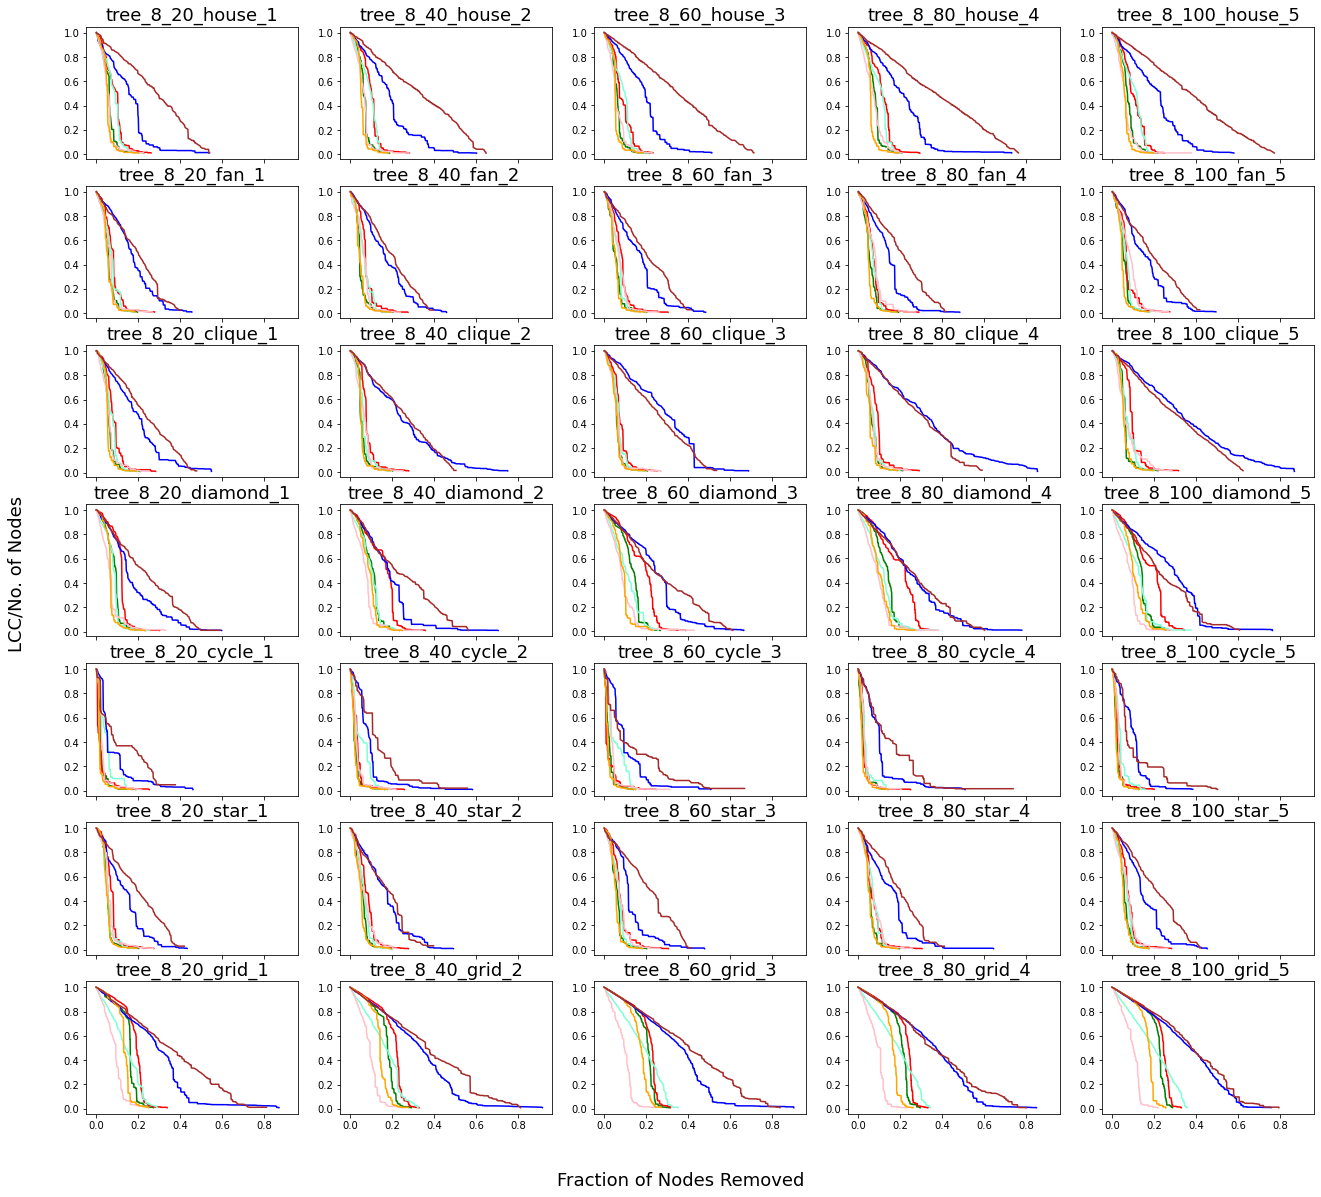

In [6]:
BA = 295500
MIX = 212500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]

file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


# Real World Dataset

corruption ,[99, 124, 71, 133, 22, 127, 58, 96, 101, 119, 32, 117, 100, 120, 151, 153, 154, 303, 157, 91, 183, 304, 162, 92, 192, 93, 94, 164, 95, 165, 38, 166, 97, 44, 47, 167, 98, 27, 102, 168, 103, 1, 169, 104, 170, 105, 4, 171, 106, 172, 173, 107, 73, 174, 108, 292, 48, 109, 175, 24, 51, 110, 176, 52, 111, 177, 53, 178, 112, 82, 54, 179, 113, 49, 60, 114, 180, 56, 62, 115, 181, 77, 63, 14, 116, 182, 210, 69, 142, 15, 17, 184, 50, 118, 121, 0, 16, 18, 55, 64, 185, 208, 228, 2, 19, 25, 57, 67, 122, 186, 209, 3, 20, 26, 59, 70, 123, 187, 203, 156, 21, 188, 61, 28, 125, 5, 136, 72, 286, 88, 206, 199, 248, 126, 128, 232, 23, 252, 34, 65, 240, 189, 260, 74, 6, 137, 213, 200, 261, 241, 212, 7, 152, 233, 190, 138, 253, 66, 29, 36, 75, 294, 155, 30, 254, 76, 78, 201, 8, 37, 191, 262, 129, 234, 139, 242, 218, 214, 250, 221, 255, 40, 158, 217, 215, 193, 130, 272, 9, 79, 31, 235, 83, 140, 263, 202, 243, 147, 251, 222, 219, 41, 159, 256, 264, 33, 204, 131, 273, 216, 85, 141, 80, 236, 268, 298, 

foodweb-baywet ,[64, 17, 62, 54, 38, 49, 50, 69, 31, 55, 93, 32, 28, 86, 88, 66, 101, 40, 102, 29, 68, 34, 61, 33, 114, 52, 47, 119, 71, 39, 87, 100, 123, 35, 51, 25, 21, 22, 48, 37, 23, 36, 53, 103, 74, 24, 73, 41, 124, 30, 122, 27, 67, 0, 72, 56, 127, 42, 125, 94, 26, 80, 85, 18, 95, 91, 77, 20, 104, 14, 16, 84, 9, 43, 99, 8, 10, 65, 44, 19, 126, 11, 15, 96]
[15, 64, 48, 55, 85, 124, 47, 32, 126, 103, 116, 42, 70, 80, 60, 75, 44, 10, 120, 63, 83, 51, 45, 77, 121, 82, 79, 0, 8, 18, 9, 58, 57, 26, 16, 97, 30, 11, 115, 20, 25, 117, 14, 78, 13, 111, 74, 27, 118, 19, 29, 112, 90, 28, 59, 5, 127, 41, 46, 2, 100, 110, 106, 84, 39, 119, 109, 88, 35, 94, 61, 98, 6, 67, 33, 62, 65, 123, 73, 86, 92, 102, 105, 34, 87, 113, 12, 40, 36, 7, 81, 21, 24, 4, 3, 43, 53, 31, 22, 1, 72, 49, 50, 76, 71, 108, 37, 23, 99, 17, 122, 107, 38, 54, 104, 125, 91, 96, 89, 56, 95]
[56, 17, 84, 20, 54, 83, 95, 96, 87, 38, 41, 71, 42, 89, 50, 103, 127, 39, 91, 104, 52, 76, 51, 98, 90, 19, 94, 77, 100, 70, 121, 116, 1

[25, 172, 192, 197, 161, 97, 313, 307, 306, 319, 95, 286, 283, 291, 85, 259, 261, 199, 228, 200, 264, 196, 245, 265, 173, 262, 80, 191, 243, 174, 183, 175, 188, 58, 249, 202, 90, 229, 204, 282, 23, 117, 57, 126, 102, 116, 24, 107, 78, 27, 270, 273, 274, 275, 227, 226, 272, 26, 152, 56, 155, 131, 244, 246, 83, 99, 316, 7, 73, 136, 96, 203, 141, 28, 201, 298, 127, 233, 166, 171, 185, 133, 22, 67, 47, 84, 151, 231, 255, 186, 147, 89, 75, 100, 290, 134, 91, 214, 211, 79, 236, 238, 3, 16, 12, 20, 5, 13, 11, 17, 4, 21, 41, 19, 18, 15, 77, 179, 178, 128, 98, 142, 187, 132, 205, 176, 140, 49, 278, 130, 198, 193, 184, 120, 169, 170, 168, 121, 10, 9, 8, 93, 144, 225, 29, 48, 124, 115, 87, 88, 252, 216, 180, 288, 66, 160, 154, 159, 82, 125, 212, 70, 109, 68, 55, 101, 321, 322, 324, 276, 320, 323, 113, 112, 71, 122, 217, 139, 135, 206, 208, 210, 215, 218, 149, 221, 318, 222, 137, 138, 213, 294, 219, 285, 86, 81, 266, 251, 53, 300, 289, 52, 220, 234, 281, 235, 108, 105, 150, 118, 106, 74, 129, 76, 

[328, 330, 0, 36, 400, 151, 57, 512, 564, 259, 258, 257, 643, 28, 136, 189, 48, 402, 641, 608, 27, 629, 132, 581, 580, 329, 298, 40, 39, 299, 301, 734, 568, 344, 569, 552, 79, 567, 45, 450, 46, 513, 293, 292, 24, 247, 415, 423, 652, 413, 383, 382, 653, 750, 145, 263, 435, 436, 732, 196, 16, 255, 593, 219, 64, 342, 396, 34, 411, 264, 281, 496, 217, 230, 229, 280, 546, 218, 52, 233, 524, 68, 705, 69, 67, 42, 446, 572, 562, 560, 561, 731, 260, 635, 637, 591, 663, 615, 418, 76, 54, 56, 175, 115, 148, 442, 276, 461, 375, 434, 209, 482, 312, 134, 242, 240, 472, 407, 642, 437, 704, 162, 534, 533, 554, 44, 278, 77, 321, 666, 245, 314, 313, 315, 632, 316, 684, 389, 679, 81, 30, 211, 673, 210, 150, 465, 614, 304, 459, 305, 101, 578, 197, 124, 246, 35, 112, 5, 628, 665, 470, 694, 95, 347, 386, 362, 317, 355, 354, 626, 657, 656, 655, 164, 18, 19, 58, 537, 644, 147, 493, 215, 192, 692, 190, 307, 510, 701, 158, 159, 126, 627, 55, 234, 664, 588, 590, 707, 452, 451, 506, 163, 480, 376, 454, 377, 398, 

[744, 679, 488, 864, 658, 434, 442, 484, 476, 812, 617, 876, 27, 904, 841, 187, 625, 326, 692, 781, 517, 239, 121, 523, 754, 609, 63, 678, 580, 424, 312, 615, 482, 199, 261, 380, 172, 162, 289, 324, 143, 310, 433, 582, 55, 371, 242, 474, 599, 803, 766, 820, 402, 8, 352, 899, 900, 607, 36, 224, 438, 571, 869, 71, 788, 669, 801, 411, 346, 230, 138, 50, 26, 684, 360, 185, 192, 365, 455, 603, 14, 246, 636, 102, 319, 100, 907, 64, 777, 174, 293, 79, 253, 101, 761, 468, 59, 197, 182, 314, 633, 67, 425, 610, 379, 82, 19, 857, 207, 437, 145, 20, 209, 550, 170, 109, 390, 210, 52, 901, 350, 202, 295, 329, 167, 574, 15, 123, 83, 137, 114, 258, 395, 228, 164, 397, 315, 846, 689, 60, 11, 611, 612, 252, 51, 417, 632, 543, 780, 439, 332, 477, 654, 160, 770, 564, 561, 394, 255, 301, 240, 163, 298, 2, 153, 103, 24, 254, 652, 84, 348, 478, 409, 171, 43, 670, 45, 426, 146, 262, 108, 225, 399, 193, 775, 136, 94, 251, 663, 37, 299, 161, 248, 91, 130, 70, 531, 479, 18, 338, 142, 682, 345, 627, 10, 572, 887,

[47, 91, 275, 27, 124, 522, 208, 5, 23, 485, 164, 129, 76, 4, 20, 706, 283, 760, 32, 547, 95, 132, 131, 39, 820, 35, 97, 699, 169, 89, 15, 586, 53, 1031, 142, 687, 321, 34, 210, 135, 284, 7, 725, 764, 748, 869, 724, 866, 537, 294, 752, 343, 708, 366, 262, 599, 495, 338, 297, 114, 181, 2, 352, 319, 1170, 959, 747, 58, 929, 1, 580, 37, 745, 46, 702, 634, 711, 853, 93, 562, 746, 766, 367, 478, 533, 368, 524, 354, 767, 207, 451, 523, 342, 482, 180, 100, 561, 206, 78, 36, 72, 201, 236, 765, 280, 185, 928, 298, 570, 632, 827, 884, 775, 68, 731, 1024, 525, 163, 140, 318, 704, 535, 924, 327, 801, 680, 759, 487, 133, 836, 148, 927, 16, 703, 782, 17, 364, 69, 28, 14, 168, 635, 816, 264, 772, 371, 1114, 222, 253, 303, 675, 45, 846, 3, 1122, 854, 762, 107, 984, 340, 389, 998, 749, 123, 73, 814, 936, 545, 579, 476, 833, 676, 339, 601, 65, 381, 272, 42, 712, 104, 657, 624, 776, 386, 146, 716, 434, 245, 313, 826, 1141, 38, 500, 435, 861, 639, 365, 94, 800, 61, 787, 1075, 184, 102, 678, 616, 426, 859,

[311, 341, 696, 532, 531, 384, 850, 1111, 1110, 312, 389, 412, 1087, 1086, 413, 1109, 647, 698, 1085, 1108, 695, 414, 975, 530, 974, 406, 51, 581, 67, 1195, 86, 132, 1058, 788, 253, 814, 112, 569, 553, 193, 130, 555, 299, 556, 88, 297, 736, 664, 707, 661, 654, 662, 839, 430, 186, 1120, 525, 1119, 1114, 1093, 1115, 395, 960, 43, 836, 808, 968, 46, 481, 275, 671, 276, 672, 487, 156, 165, 819, 820, 1118, 790, 1092, 166, 45, 44, 793, 794, 795, 134, 1006, 267, 1225, 855, 268, 603, 1157, 650, 621, 972, 639, 971, 1158, 613, 649, 1159, 693, 692, 108, 675, 730, 201, 578, 169, 840, 111, 400, 1209, 401, 526, 1073, 1079, 1074, 212, 224, 233, 228, 239, 774, 71, 114, 492, 141, 807, 101, 1018, 149, 656, 109, 683, 663, 217, 745, 221, 440, 441, 439, 248, 436, 746, 929, 1061, 1062, 522, 1151, 1182, 1147, 1164, 1204, 1025, 1205, 1152, 1153, 1202, 1165, 1199, 1189, 1175, 1024, 1190, 1166, 1200, 944, 1146, 1154, 1176, 1206, 1177, 1155, 854, 1203, 1156, 853, 81, 421, 300, 357, 891, 356, 9, 28, 420, 10, 179,

[289, 288, 287, 0, 290, 2687, 291, 768, 2629, 1826]
[289, 288, 0, 2687, 768, 2629, 1826, 1727, 700, 1825, 1824, 1823, 1822, 1821, 1820, 1819, 1818, 1817, 1816, 1815, 1814, 1813, 1812, 1811, 1810, 1809, 1808, 1807, 1806, 1805, 1804, 1803, 1802, 1801, 1800, 1799, 1798, 1797, 1796, 1795, 1794, 1793, 1792, 1791, 1790, 1789, 1788, 1787, 1786, 1785, 1784, 1783, 1782, 1781, 1780, 1779, 1778, 1777, 1776, 1775, 1774, 1773, 1772, 1771, 1770, 1769, 1768, 1767, 1766, 1765, 1764, 1763, 1762, 1761, 1760, 1759, 1758, 1757, 1756, 1755, 1754, 1753, 1752, 1751, 1750, 1749, 1748, 1747, 1746, 1745, 1744, 1743, 1742, 1741, 1740, 1739, 1738, 1737, 1736, 1735, 1734, 1732, 1731, 1730, 1729, 1728, 1726, 1725, 1724, 1722, 1719, 1717, 1716, 1714, 1713, 1712, 1711, 1710, 1709, 1707, 1705, 1704, 1703, 1702, 1701, 1700, 1699, 1698, 1697, 1696, 1695, 1694, 1693, 1692, 1691, 1690, 1688, 1687, 1686, 1685, 1684, 1683, 1682, 419, 1678, 1677, 1676, 1675, 1674, 1673, 1671, 1670, 1669, 1668, 1667, 1665, 1664, 1663, 1661, 1

[720, 472, 496, 513, 529, 587, 597, 641, 713, 714, 715, 2254, 2258, 2272, 2307, 2346, 2354, 2363, 2371, 2384, 2386, 2428, 2432, 2250, 2253, 2256, 2288, 2297, 2301, 2304, 2309, 2311, 2336, 2377, 2385, 2413, 2420, 2423, 2425, 2426, 716, 719, 70, 246, 2646, 2649, 2651, 2644, 34, 216, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 47, 48, 51, 53, 54, 56, 57, 58, 60, 62, 63, 64, 65, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 92, 93, 94, 96, 98, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 115, 116, 118, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 161, 165, 166, 169, 170, 171, 172, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 214, 215, 218, 219, 223, 

[290, 1566, 1572, 1649, 1727, 216, 1662, 1545, 1606, 1715, 1628, 1672, 1551, 1592, 1563, 1641, 1549, 89, 1720, 1602, 1604, 1666, 1567, 1658, 1591, 1721, 1553, 718, 717, 1708, 1706, 713, 715, 1680, 1631, 1718, 1679, 1723, 1596, 1548, 1689, 1681, 1599, 714, 1583, 1826, 2745, 2772, 2830, 2776, 2698, 2729, 2823, 2708, 1525, 2803, 2828, 2804, 2810, 2747, 2805, 2840, 2719, 2800, 2774, 2856, 2825, 2753, 2687, 2713, 287, 513, 626, 764, 597, 472, 722, 587, 721, 496, 529, 720, 641, 712, 0, 34, 70, 68, 289, 246, 291, 716, 719, 288]
powergrid ,[4620, 4630, 3138, 191, 869, 4648, 560, 4634, 2991, 2944, 2864, 1593, 4632, 2926, 2971, 912, 642, 756, 4626, 3036, 848, 3667, 2997, 1773, 442, 918, 636, 4189, 2022, 286, 1166, 867, 485, 4678, 1258, 850, 690, 3132, 263, 2940, 1080, 670, 1804, 3124, 1566, 1184, 1050, 3789, 1974, 1925, 2913, 516, 3271, 586, 881, 904, 3376, 2895, 2333, 1707, 113, 26, 945, 1130, 122, 1683, 4615, 39, 785, 4185, 372, 2663, 1396, 1979, 960, 3044, 793, 4375, 4214, 138, 1416, 3884, 98

[197, 3136, 2871, 658, 2790, 2427, 2740, 786, 611, 660, 2705, 1401, 575, 529, 1436, 3571, 4045, 3627, 2447, 3038, 2658, 2801, 63, 1337, 2903, 2760, 1638, 1025, 1099, 1446, 2704, 850, 2989, 3651, 2756, 4012, 657, 1643, 102, 4014, 3867, 144, 4361, 650, 2850, 34, 2794, 4314, 3234, 2874, 2707, 1631, 816, 1339, 2807, 696, 2718, 672, 1206, 2827, 2685, 53, 2072, 166, 2686, 489, 4551, 4343, 2952, 1252, 1431, 567, 964, 2660, 3059, 3179, 4532, 841, 2754, 3215, 2858, 1363, 1352, 1014, 930, 3517, 1322, 2872, 566, 2499, 155, 3262, 2657, 3325, 2600, 3327, 1498, 1501, 4536, 2787, 2746, 57, 4556, 3635, 1260, 2982, 4202, 2667, 3519, 1791, 3668, 276, 2123, 173, 2530, 3888, 711, 514, 1327, 1151, 2898, 4357, 3766, 2881, 2882, 1128, 1433, 3569, 4051, 4871, 3601, 4029, 513, 865, 814, 661, 3567, 3620, 4247, 670, 4388, 2724, 545, 1030, 3503, 4763, 654, 2699, 4516, 22, 4324, 3525, 2531, 3164, 4027, 2767, 70, 2785, 655, 4061, 1620, 385, 3848, 1816, 4020, 3818, 2659, 3637, 3691, 3173, 1075, 348, 2696, 671, 4782,

[3050, 3598, 934, 3488, 2643, 3808, 1737, 3122, 1408, 4574, 1616, 4475, 2166, 4545, 4208, 650, 4187, 4292, 1818, 2838, 1, 1742, 1091, 2704, 999, 668, 718, 1556, 2055, 2934, 2130, 2153, 4110, 3219, 59, 3894, 138, 3478, 541, 1449, 1079, 3658, 2923, 463, 2081, 1482, 2946, 2053, 177, 3995, 3965, 4214, 3754, 683, 647, 2137, 1954, 1670, 4117, 4173, 233, 559, 75, 4464, 1572, 4848, 3771, 2265, 1955, 1533, 4075, 4521, 2050, 20, 1655, 3310, 4916, 2772, 240, 3533, 3857, 3535, 1849, 1206, 1984, 15, 3260, 959, 3792, 1165, 4356, 149, 4235, 1092, 2641, 3254, 2275, 3702, 937, 3191, 54, 112, 446, 1922, 871, 3281, 4826, 3868, 1566, 419, 2066, 3249, 3815, 3023, 1591, 3708, 3119, 496, 3715, 998, 3253, 2957, 925, 497, 4795, 635, 3579, 3933, 116, 551, 3747, 3683, 4932, 1026, 1563, 1847, 3974, 2845, 1681, 1302, 2645, 2766, 2804, 1327, 2372, 4893, 879, 3549, 122, 1630, 2469, 2317, 4812, 785, 4711, 3734, 3054, 275, 401, 485, 2799, 1048, 1409, 2239, 2969, 3721, 1700, 2322, 1579, 4185, 705, 1328, 847, 4387, 3145

[3136, 3180, 3200, 3199, 3133, 3135, 3195, 2969, 3194, 3134, 3197, 3193, 4516, 4580, 4581, 4537, 4582, 2699, 3286, 2700, 2892, 3285, 2891, 4045, 4123, 4124, 4121, 4122, 4130, 4125, 4179, 4128, 4181, 4127, 4129, 660, 668, 680, 666, 667, 2705, 2709, 2721, 2722, 2703, 2717, 2720, 2716, 2802, 2714, 2719, 2427, 2435, 2432, 2436, 2431, 2437, 2441, 2439, 2433, 2434, 2430, 2489, 2438, 2576, 4524, 2746, 2764, 2747, 197, 762, 761, 1098, 286, 763, 284, 132, 529, 539, 537, 527, 528, 535, 2543, 538, 534, 4546, 4553, 657, 1903, 1905, 1785, 3186, 3161, 3160, 3503, 3495, 3629, 3623, 3624, 1327, 1334, 491, 1338, 4012, 4062, 4067, 4066, 4063, 4065, 4005, 4183, 4068, 4002, 4069, 241, 1226, 1225, 1436, 1469, 1479, 1440, 1471, 1470, 1480, 1638, 1647, 1645, 1646, 1644, 2187, 1651, 1650, 1648, 1649, 2189, 2185, 2188, 2136, 4525, 4557, 4584, 4583, 2740, 2744, 2741, 2750, 2749, 2774, 2753, 2743, 672, 3106, 3107, 674, 2730, 3038, 673, 2898, 3062, 3063, 3058, 3064, 1631, 1664, 1675, 1666, 1667, 1662, 1473, 1672,

netscience ,[45, 44, 133, 202, 945, 285, 946, 964, 944, 947, 948, 239, 286, 206, 645, 46, 949, 604, 950, 951, 952, 296, 953, 602, 48, 54, 1223, 354, 85, 538, 82, 606, 1248, 305, 451, 1055, 954, 273, 170, 646, 49, 243, 355, 557, 161, 603, 303, 356, 649, 452, 276, 1056, 1283, 955, 1224, 535, 240, 111, 310, 453, 761, 718, 1057, 1284, 956, 217, 87, 245, 809, 1246, 1225, 153, 327, 277, 832, 1285, 169, 1226, 1058, 204, 454, 537, 1339, 112, 105, 96, 1197, 762, 810, 957, 1247, 870, 357, 536, 971, 344, 250, 175, 611, 736, 648, 1262, 17, 117, 92, 232, 61, 1127, 582, 680, 1070, 879, 958, 426, 811, 143, 1249, 1227, 763, 253, 455, 1033, 1059, 1162, 1286, 777, 666, 106, 55, 130, 655, 620, 705, 464, 569, 244, 871, 1421, 32, 213, 589, 241, 311, 343, 413, 577, 717, 1090, 174, 11, 551, 321, 205, 644, 4, 100, 144, 254, 456, 512, 275, 81, 734, 764, 812, 817, 959, 407, 441, 1034, 1060, 1094, 1109, 368, 1163, 1177, 1182, 1196, 1228, 1250, 1278, 1287, 1390, 1128, 508, 630, 331, 831, 849, 294, 139, 190, 151, 

[106, 43, 101, 123, 124, 45, 44, 84, 298, 185, 328, 204, 184, 243, 172, 173, 170, 40, 466, 475, 53, 191, 748, 556, 120, 81, 796, 197, 208, 410, 426, 423, 209, 1183, 307, 535, 1036, 236, 395, 766, 747, 47, 588, 531, 135, 1098, 1100, 1095, 565, 332, 792, 503, 502, 791, 86, 589, 54, 505, 987, 411, 125, 326, 345, 416, 551, 343, 915, 736, 1159, 267, 1363, 1339, 1264, 1251, 1176, 143, 574, 1116, 276, 1096, 1097, 1058, 1015, 951, 234, 934, 228, 894, 893, 892, 425, 376, 743, 362, 710, 623, 1235, 608, 17, 578, 35, 34, 284, 285, 555, 559, 271, 268, 163, 642, 166, 640, 980, 164, 641, 638, 1055, 1429, 979, 1348, 1427, 1120, 206, 507, 1349, 429, 1425, 430, 506, 108, 1347, 1426, 474, 749, 751, 432, 554, 414, 415, 225, 468, 1151, 36, 1370, 1368, 1365, 1364, 1361, 1360, 1358, 1356, 1354, 1353, 1351, 674, 167, 673, 672, 1345, 1343, 1341, 1338, 1336, 1335, 1334, 1333, 1332, 1331, 1330, 1329, 1327, 1326, 1325, 1323, 1322, 1320, 1318, 1317, 1315, 1313, 1311, 1309, 1307, 1305, 1304, 1303, 1301, 1300, 1298,

[62, 536, 557, 169, 161, 232, 304, 58, 296, 310, 152, 117, 153, 61, 177, 106, 205, 85, 347, 199, 276, 357, 275, 80, 175, 537, 311, 184, 303, 277, 508, 630, 17, 849, 879, 1339, 718, 524, 1350, 831, 241, 1070, 777, 5, 513, 1112, 1179, 1180, 1390, 1391, 1394, 479, 613, 615, 712, 729, 775, 807, 968, 970, 996, 1010, 1026, 1077, 1154, 1304, 1335, 1395, 1404, 1447, 1453, 25, 27, 28, 29, 40, 237, 238, 377, 386, 387, 423, 424, 425, 494, 496, 502, 530, 532, 533, 534, 596, 597, 598, 643, 742, 753, 788, 790, 797, 889, 890, 990, 991, 992, 1015, 1030, 1065, 1082, 1084, 1108, 1120, 1124, 1137, 1143, 1144, 1145, 1157, 1170, 1240, 1241, 1244, 1302, 1312, 1329, 1332, 1359, 1360, 1382, 1384, 1388, 1413, 1418, 1432, 1439, 1441, 413, 1090, 1248, 971, 762, 764, 765, 705, 32, 33, 589, 881, 872, 1285, 416, 417, 691, 699, 1005, 1275, 407, 708, 744, 706, 1197, 398, 499, 1114, 1262, 146, 147, 1033, 1037, 1162, 1165, 1167, 648, 243, 761, 1218, 1060, 379, 381, 692, 737, 734, 582, 1372, 572, 575, 1259, 261, 577, 6,

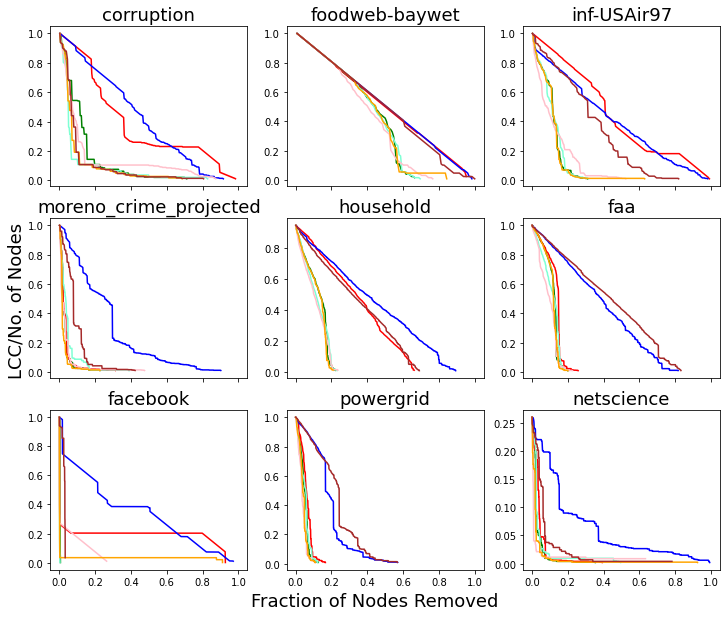

In [7]:
BA = 295500
MIX = 212500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]

file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'household','faa','facebook','powergrid','netscience']
graph_path =  "./Dataset/Real/"
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Real",grid_plot,[x,y])


## Cancer Gene

COAD ,[319, 297, 566, 457, 2, 346, 490, 5, 443, 349, 8, 388, 438, 819, 902, 970, 321, 168, 2145, 7, 437, 1166, 1621, 1168, 6, 2445, 296, 300, 341, 2447, 803, 450, 18, 626, 2161, 420, 283, 4, 403, 2147, 292, 1, 1321, 969, 229, 1363, 2157, 13, 1882, 497, 2639, 1955, 694, 446, 38, 1362, 2149, 330, 2171, 384, 439, 1284, 3, 2501, 431, 2167, 345, 742, 2175, 1015, 2160, 316, 930, 701, 735, 2172, 304, 94, 1335, 541, 2151, 462, 428, 445, 309, 121, 352, 2156, 897, 145, 1532, 1497, 1541, 293, 2169, 2446, 386, 2141, 646, 239, 305, 595, 1200, 1028, 972, 693, 79, 597, 755, 2152, 814, 1135, 954, 383, 653, 1083, 61, 805, 1194, 2148, 905, 1179, 616, 278, 1530, 521, 85, 887, 2637, 799, 652, 1062, 1088, 1392, 1078, 227, 940, 2069, 453, 307, 338, 728, 402, 1318, 2890, 2164, 56, 899, 794, 1800, 651, 452, 422, 427, 224, 306, 756, 415, 948, 2245, 441, 1002, 2645, 779, 362, 182, 957, 713, 328, 279, 295, 1048, 787, 147, 933, 2058, 894, 1801, 729, 442, 1099, 455, 798, 406, 493, 461, 771, 1571, 888, 962, 1727, 1

FileNotFoundError: ./ReI_CI/COAD.txt not found.

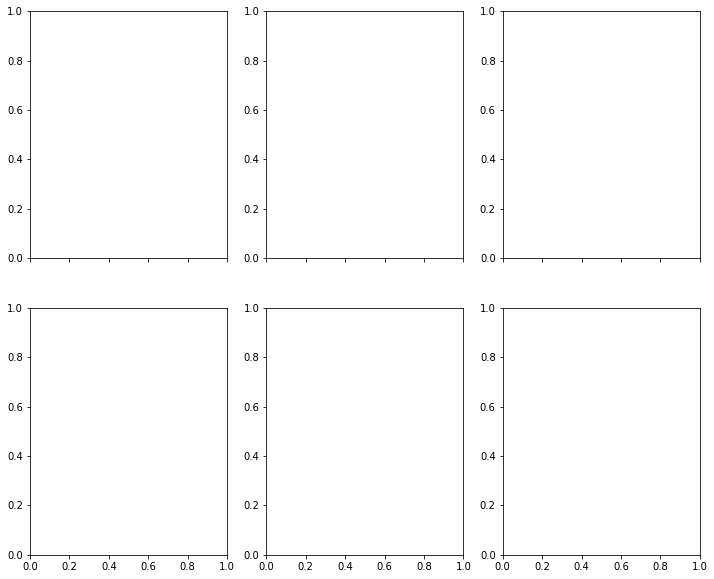

In [8]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])